# CLuster de Usuarios

1. Feature engeneering, agregacoes por hora, sessao e dia,
2. nao criar a feature de risco
3. clusterizar jogadores, com alguma metrica, gadam
4. estudar o cluster mais saudavel
5. criar o autoencoder desse cluster
6. ver a distancia do cluster ao longo do tempo
7. prever essa distancia no futuro como um ts







In [ ]:

import pandas as pd
import numpy as np
import gc

from scipy.stats import linregress

# from sklearn import metrics
from sklearn.preprocessing import StandardScaler, RobustScaler
# from sklearn.metrics import silhouette_score, mean_absolute_error, r2_score
# from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# import hdbscan
# from hdbscan import prediction
# from itertools import product

from pycaret.clustering import *

# from lightgbm import LGBMRegressor, plot_importance

from helper.model_plots import *
#plots personalizados

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [ ]:
usecols = ['game_id', 'user_id', 'bet_id', 'game_type', 'odds', 'fiat_bet_amount',
       'fiat_profit_amount','fiat_is_valuable']


bets_dtypes = {
    'game_id': 'uint32',
    'user_id': 'uint32',
    'bet_id': 'uint64',
    'game_type': 'category',
    'odds': 'float32',
    'fiat_is_valuable': 'category',
    'fiat_bet_amount': 'float32',
    'fiat_profit_amount': 'float32',
}

bets = pd.read_csv("data/bets.csv", usecols=usecols, dtype=bets_dtypes)
# bets = bets[bets['fiat_is_valuable'] == 't']


In [ ]:
bets.head()


,game_id,user_id,bet_id,game_type,odds,fiat_is_valuable,fiat_bet_amount,fiat_profit_amount
0,2828375,173570,210854317,normal,0.0,t,0.048738,-0.048738
1,2828375,1339924,12148553,yellow,0.0,f,NaN,NaN
2,2828375,1139219,210854260,normal,2.0,t,0.000088,0.000088
3,2828375,1329183,12148544,yellow,0.0,t,0.188109,-0.188109
4,2828375,1378328,210854292,normal,0.0,t,0.000005,-0.000005


In [ ]:
games_usecols = ['game_id', 'max_rate', 'date'] # ,'bet_count']

games_dtypes = {
    'game_id': 'uint32',
    'max_rate': 'float32',
    # 'bet_count': 'uint32',
}

games = pd.read_csv("data/games.csv", usecols=games_usecols, dtype=games_dtypes, parse_dates=['date'])


In [ ]:

games.head()


,game_id,max_rate,date
0,2828375,6.430000,2020-09-08 23:30:13
1,2828376,2.100000,2020-09-08 23:30:35
2,2828377,3.110000,2020-09-08 23:31:03
3,2828378,24.969999,2020-09-08 23:32:07
4,2828379,1.040000,2020-09-08 23:32:17


In [ ]:
df = pd.merge(bets, games, on='game_id', how='left')



In [ ]:
del bets, games
gc.collect()


0

In [35]:
df.sort_values(['user_id','game_id'], kind='stable', inplace=True, ignore_index=True)



In [36]:
df.user_id.nunique(), df.game_id.nunique(), df.bet_id.nunique()



(50039, 71505, 25700215)

In [37]:
df['date'].max(), df['date'].min()


(Timestamp('2020-09-30 07:10:37'), Timestamp('2020-09-08 23:30:13'))

In [38]:
df['date'].max() - df['date'].min()


Timedelta('21 days 07:40:24')

In [39]:
df.head()


,game_id,user_id,bet_id,game_type,odds,fiat_is_valuable,fiat_bet_amount,fiat_profit_amount,max_rate,date
0,2831698,44,212042687,normal,1.03,t,0.000034,0.000001,2.370000,2020-09-09 22:51:14
1,2831768,44,212067364,normal,1.03,t,0.000034,0.000001,2.070000,2020-09-09 23:26:45
2,2831820,44,212085405,normal,1.08,t,0.000034,0.000003,1.150000,2020-09-09 23:48:26
3,2832628,44,212376980,normal,1.67,t,0.000035,0.000024,2.060000,2020-09-10 05:36:11
4,2832686,44,212397916,normal,2.00,t,0.000140,0.000140,328.890015,2020-09-10 06:01:38


In [40]:
df.columns


Index(['game_id', 'user_id', 'bet_id', 'game_type', 'odds', 'fiat_is_valuable',
       'fiat_bet_amount', 'fiat_profit_amount', 'max_rate', 'date'],
      dtype='object')

In [41]:
df = df[df['fiat_is_valuable'] == 't']
df = df.drop(columns=['fiat_is_valuable'])


In [42]:
df.user_id.nunique(), df.game_id.nunique(), df.bet_id.nunique()


(32102, 71499, 23335924)

In [43]:
df.head(20)


,game_id,user_id,bet_id,game_type,odds,fiat_bet_amount,fiat_profit_amount,max_rate,date
0,2831698,44,212042687,normal,1.03,0.000034,1.013535e-06,2.370000,2020-09-09 22:51:14
1,2831768,44,212067364,normal,1.03,0.000034,1.013535e-06,2.070000,2020-09-09 23:26:45
2,2831820,44,212085405,normal,1.08,0.000034,2.702760e-06,1.150000,2020-09-09 23:48:26
3,2832628,44,212376980,normal,1.67,0.000035,2.353256e-05,2.060000,2020-09-10 05:36:11
4,2832686,44,212397916,normal,2.00,0.000140,1.404929e-04,328.890015,2020-09-10 06:01:38
5,2832689,44,212399028,normal,0.00,0.000140,-1.404929e-04,1.100000,2020-09-10 06:02:47
6,2832690,44,212399332,normal,2.00,0.000281,2.809858e-04,2.950000,2020-09-10 06:03:14
7,2832691,44,212399705,normal,2.00,0.000140,1.404929e-04,7.670000,2020-09-10 06:03:57
8,2837444,44,214069523,normal,1.03,0.000037,1.102917e-06,3.310000,2020-09-11 15:26:11
9,2843418,44,216156160,normal,1.02,0.000039,7.754470e-07,4.460000,2020-09-13 10:25:25


In [44]:
conditions = [
    (df['game_type'] == 'normal') & (df['odds'] == 0),
    (df['game_type'] == 'green'),
    (df['game_type'] == 'red'),
    (df['game_type'] == 'yellow')
]

values = [
    df['max_rate'],
    2,
    1.96,
    10
]

df['odds_adjusted'] = np.select(conditions, values, default=df['odds'])


In [45]:
df.head()


,game_id,user_id,bet_id,game_type,odds,fiat_bet_amount,fiat_profit_amount,max_rate,date,odds_adjusted
0,2831698,44,212042687,normal,1.03,0.000034,0.000001,2.370000,2020-09-09 22:51:14,1.03
1,2831768,44,212067364,normal,1.03,0.000034,0.000001,2.070000,2020-09-09 23:26:45,1.03
2,2831820,44,212085405,normal,1.08,0.000034,0.000003,1.150000,2020-09-09 23:48:26,1.08
3,2832628,44,212376980,normal,1.67,0.000035,0.000024,2.060000,2020-09-10 05:36:11,1.67
4,2832686,44,212397916,normal,2.00,0.000140,0.000140,328.890015,2020-09-10 06:01:38,2.00


In [46]:
df.head(100)


,game_id,user_id,bet_id,game_type,odds,fiat_bet_amount,fiat_profit_amount,max_rate,date,odds_adjusted
0,2831698,44,212042687,normal,1.03,0.000034,0.000001,2.370000,2020-09-09 22:51:14,1.03
1,2831768,44,212067364,normal,1.03,0.000034,0.000001,2.070000,2020-09-09 23:26:45,1.03
2,2831820,44,212085405,normal,1.08,0.000034,0.000003,1.150000,2020-09-09 23:48:26,1.08
3,2832628,44,212376980,normal,1.67,0.000035,0.000024,2.060000,2020-09-10 05:36:11,1.67
4,2832686,44,212397916,normal,2.00,0.000140,0.000140,328.890015,2020-09-10 06:01:38,2.00
...,...,...,...,...,...,...,...,...,...,...
95,2828664,5588,12159782,yellow,0.00,7.090167,-7.090167,2.410000,2020-09-09 01:32:42,10.00
96,2828665,5588,12159820,red,0.00,1.772542,-1.772542,7.400000,2020-09-09 01:33:25,1.96
97,2828665,5588,12159822,green,2.00,0.886271,0.886271,7.400000,2020-09-09 01:33:25,2.00
98,2828666,5588,12159859,green,2.00,7.090167,7.090167,3.030000,2020-09-09 01:33:52,2.00


In [47]:
past_bets = df.groupby("user_id")["fiat_bet_amount"].shift(1)

df["user_bet_mean_weighted"] = (
    past_bets
    .groupby(df["user_id"])
    .transform(lambda s: s.ewm(alpha=0.01, adjust=False).mean())
)
df["user_bet_mean_weighted"] = df["user_bet_mean_weighted"].fillna(
    df.groupby("user_id")["fiat_bet_amount"].transform("first")
)

df["user_bet_amount_proportion"] = df["fiat_bet_amount"] / df["user_bet_mean_weighted"]


In [48]:
df.head(10)


,game_id,user_id,bet_id,game_type,odds,fiat_bet_amount,fiat_profit_amount,max_rate,date,odds_adjusted,user_bet_mean_weighted,user_bet_amount_proportion
0,2831698,44,212042687,normal,1.03,0.000034,1.013535e-06,2.370000,2020-09-09 22:51:14,1.03,0.000034,1.000000
1,2831768,44,212067364,normal,1.03,0.000034,1.013535e-06,2.070000,2020-09-09 23:26:45,1.03,0.000034,1.000000
2,2831820,44,212085405,normal,1.08,0.000034,2.702760e-06,1.150000,2020-09-09 23:48:26,1.08,0.000034,1.000000
3,2832628,44,212376980,normal,1.67,0.000035,2.353256e-05,2.060000,2020-09-10 05:36:11,1.67,0.000034,1.039625
4,2832686,44,212397916,normal,2.00,0.000140,1.404929e-04,328.890015,2020-09-10 06:01:38,2.00,0.000034,4.156854
5,2832689,44,212399028,normal,0.00,0.000140,-1.404929e-04,1.100000,2020-09-10 06:02:47,1.10,0.000035,4.029644
6,2832690,44,212399332,normal,2.00,0.000281,2.809858e-04,2.950000,2020-09-10 06:03:14,2.00,0.000036,7.822300
7,2832691,44,212399705,normal,2.00,0.000140,1.404929e-04,7.670000,2020-09-10 06:03:57,2.00,0.000038,3.661361
8,2837444,44,214069523,normal,1.03,0.000037,1.102917e-06,3.310000,2020-09-11 15:26:11,1.03,0.000039,0.933260
9,2843418,44,216156160,normal,1.02,0.000039,7.754470e-07,4.460000,2020-09-13 10:25:25,1.02,0.000039,0.984903


In [49]:
# gamma = 0.8
# delta = 0.2
# raw = gamma * np.log(df["odds_adjusted"]) + delta * np.log(df["user_bet_amount_proportion"])
# # raw = np.log(df["odds_adjusted"] * df["user_bet_amount_proportion"])

# mu = raw.mean()
# sd = raw.std() + 1e-12
# df["bet_risk"] = (raw - mu) / sd 





In [50]:
df["odds_log"] = np.log(df["odds_adjusted"])
df["bets_log"] = np.log(df["user_bet_amount_proportion"])


In [51]:
df['user_id'].unique()


array([     44,      46,    5588, ..., 1503516, 1503542, 1503546],
      dtype=uint32)

In [52]:

# df[df['user_id'] == 5588].head(60)


In [53]:
# df['time'] = df['date'].dt.time
df['hour'] = df['date'].dt.hour
# df['day'] = df['date'].dt.date
df['day_of_week'] = df['date'].dt.dayofweek
df['day_of_year'] = df['date'].dt.dayofyear
df['week_of_year'] = df['date'].dt.isocalendar().week





In [54]:
df.head()


,game_id,user_id,bet_id,game_type,odds,fiat_bet_amount,fiat_profit_amount,max_rate,date,odds_adjusted,user_bet_mean_weighted,user_bet_amount_proportion,odds_log,bets_log,hour,day_of_week,day_of_year,week_of_year
0,2831698,44,212042687,normal,1.03,0.000034,0.000001,2.370000,2020-09-09 22:51:14,1.03,0.000034,1.000000,0.029559,0.000000,22,2,253,37
1,2831768,44,212067364,normal,1.03,0.000034,0.000001,2.070000,2020-09-09 23:26:45,1.03,0.000034,1.000000,0.029559,0.000000,23,2,253,37
2,2831820,44,212085405,normal,1.08,0.000034,0.000003,1.150000,2020-09-09 23:48:26,1.08,0.000034,1.000000,0.076961,0.000000,23,2,253,37
3,2832628,44,212376980,normal,1.67,0.000035,0.000024,2.060000,2020-09-10 05:36:11,1.67,0.000034,1.039625,0.512824,0.038860,5,3,254,37
4,2832686,44,212397916,normal,2.00,0.000140,0.000140,328.890015,2020-09-10 06:01:38,2.00,0.000034,4.156854,0.693147,1.424759,6,3,254,37


In [55]:
def downcast_df(df: pd.DataFrame) -> pd.DataFrame:
    float_cols = df.select_dtypes(include=['float64','float32']).columns
    df[float_cols] = df[float_cols].astype('float32', copy=False)

    int_cols = df.select_dtypes(include=['int64','int32','int']).columns
    for c in int_cols:
        if df[c].min() >= 0 and df[c].max() <= np.iinfo(np.uint32).max:
            df[c] = df[c].astype('uint32', copy=False)
        else:
            df[c] = df[c].astype('int32', copy=False)


    if 'user_id' in df.columns:
        df['user_id'] = df['user_id'].astype('category')


    if 'game_id' in df.columns:
        df['game_id'] = df['game_id'].astype('category')

    gc.collect()
    return df


In [56]:
df = downcast_df(df)


In [57]:
df.head()


,game_id,user_id,bet_id,game_type,odds,fiat_bet_amount,fiat_profit_amount,max_rate,date,odds_adjusted,user_bet_mean_weighted,user_bet_amount_proportion,odds_log,bets_log,hour,day_of_week,day_of_year,week_of_year
0,2831698,44,212042687,normal,1.03,0.000034,0.000001,2.370000,2020-09-09 22:51:14,1.03,0.000034,1.000000,0.029559,0.000000,22,2,253,37
1,2831768,44,212067364,normal,1.03,0.000034,0.000001,2.070000,2020-09-09 23:26:45,1.03,0.000034,1.000000,0.029559,0.000000,23,2,253,37
2,2831820,44,212085405,normal,1.08,0.000034,0.000003,1.150000,2020-09-09 23:48:26,1.08,0.000034,1.000000,0.076961,0.000000,23,2,253,37
3,2832628,44,212376980,normal,1.67,0.000035,0.000024,2.060000,2020-09-10 05:36:11,1.67,0.000034,1.039625,0.512824,0.038860,5,3,254,37
4,2832686,44,212397916,normal,2.00,0.000140,0.000140,328.890015,2020-09-10 06:01:38,2.00,0.000034,4.156854,0.693147,1.424759,6,3,254,37


In [58]:
# df = df.drop(columns=['game_type','odds','max_rate','odds_adjusted','user_bet_amount_proportion','user_bet_mean_weighted'])
df = df.drop(columns=['game_type','odds','max_rate','user_bet_mean_weighted'])
df.head()


,game_id,user_id,bet_id,fiat_bet_amount,fiat_profit_amount,date,odds_adjusted,user_bet_amount_proportion,odds_log,bets_log,hour,day_of_week,day_of_year,week_of_year
0,2831698,44,212042687,0.000034,0.000001,2020-09-09 22:51:14,1.03,1.000000,0.029559,0.000000,22,2,253,37
1,2831768,44,212067364,0.000034,0.000001,2020-09-09 23:26:45,1.03,1.000000,0.029559,0.000000,23,2,253,37
2,2831820,44,212085405,0.000034,0.000003,2020-09-09 23:48:26,1.08,1.000000,0.076961,0.000000,23,2,253,37
3,2832628,44,212376980,0.000035,0.000024,2020-09-10 05:36:11,1.67,1.039625,0.512824,0.038860,5,3,254,37
4,2832686,44,212397916,0.000140,0.000140,2020-09-10 06:01:38,2.00,4.156854,0.693147,1.424759,6,3,254,37


In [59]:
bets = df.copy()
bets.to_parquet('data/bets.parquet',engine='fastparquet')


In [2]:
bets = pd.read_parquet('data/bets.parquet',engine='fastparquet')


In [7]:
bets.sort_values('game_id')


,game_id,user_id,bet_id,fiat_bet_amount,fiat_profit_amount,date,odds_adjusted,user_bet_amount_proportion,odds_log,bets_log,hour,day_of_week,day_of_year,week_of_year
index,,,,,,,,,,,,,,
19486233,2828375,1408934,210854432,1.006410e-01,1.006410e-01,2020-09-08 23:30:13,2.00,1.000000e+00,0.693147,0.000000,23,1,252,37
10687058,2828375,1225837,12148556,1.306994e-06,-1.306994e-06,2020-09-08 23:30:13,1.96,1.000000e+00,0.672944,0.000000,23,1,252,37
2247848,2828375,367240,210854355,1.254714e-11,6.273571e-11,2020-09-08 23:30:13,6.00,1.000000e+00,1.791759,0.000000,23,1,252,37
21116706,2828375,1430721,210854390,8.287557e+00,8.287557e+00,2020-09-08 23:30:13,2.00,1.000000e+00,0.693147,0.000000,23,1,252,37
20264068,2828375,1421510,210854353,1.306994e-05,4.665969e-05,2020-09-08 23:30:13,4.57,1.000000e+00,1.519513,0.000000,23,1,252,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13920454,2899999,1301016,237081064,5.739347e-05,-5.739347e-05,2020-09-30 07:10:37,2.78,9.796996e-01,1.022451,-0.020509,7,2,274,40
6849805,2899999,1043215,237081222,6.525582e-03,6.525582e-03,2020-09-30 07:10:37,2.00,4.659062e-01,0.693147,-0.763771,7,2,274,40
23105185,2899999,1450886,237081080,1.912178e-08,-1.912178e-08,2020-09-30 07:10:37,2.78,3.873392e-01,1.022451,-0.948455,7,2,274,40


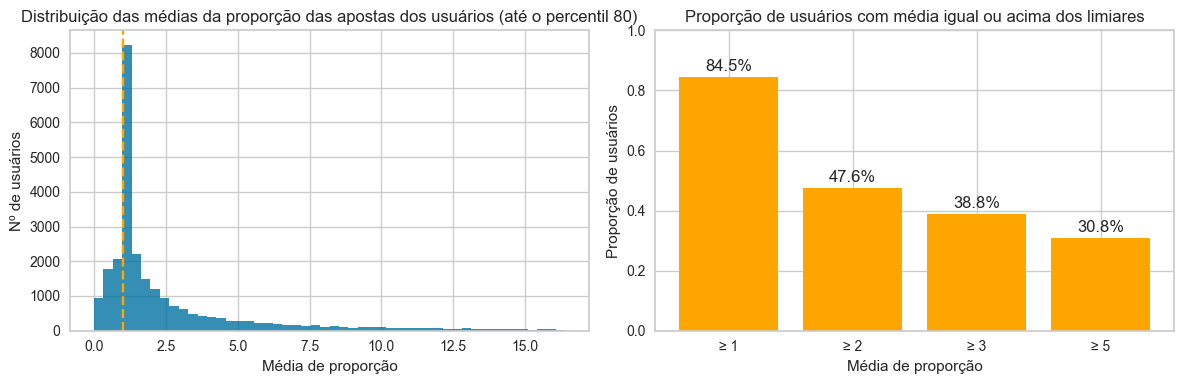

In [16]:
def plot_users_bet_analysis(df):
    u = df.groupby('user_id', observed=True).agg({
        'user_bet_amount_proportion': 'mean'
    })
    amount = u['user_bet_amount_proportion']
    thresholds = [1, 2, 3, 5]
    props = [(amount >= t).mean() for t in thresholds]  # proporção >= limiar

    
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

   
    p80 = amount.quantile(0.80)
    axs[0].hist(
        amount,
        bins=50,
        range=(amount.min(), p80),
        alpha=0.8
    )
    axs[0].axvline(1, linestyle='--', color='orange')
    axs[0].set_title('Distribuição das médias da proporção das apostas dos usuários (até o percentil 80)')
    axs[0].set_xlabel('Média de proporção')
    axs[0].set_ylabel('Nº de usuários')

    
    labels = [f'≥ {t}' for t in thresholds]
    axs[1].bar(labels, props, color="orange")
    axs[1].set_ylim(0, 1)
    axs[1].set_title('Proporção de usuários com média igual ou acima dos limiares')
    axs[1].set_xlabel('Média de proporção')
    axs[1].set_ylabel('Proporção de usuários')
    for i, p in enumerate(props):
        axs[1].text(i, p + 0.02, f'{p*100:.1f}%', ha='center')

    plt.tight_layout()
    plt.savefig("figs/p4.pdf", dpi=300, bbox_inches="tight")
    plt.show()

plot_users_bet_analysis(bets)


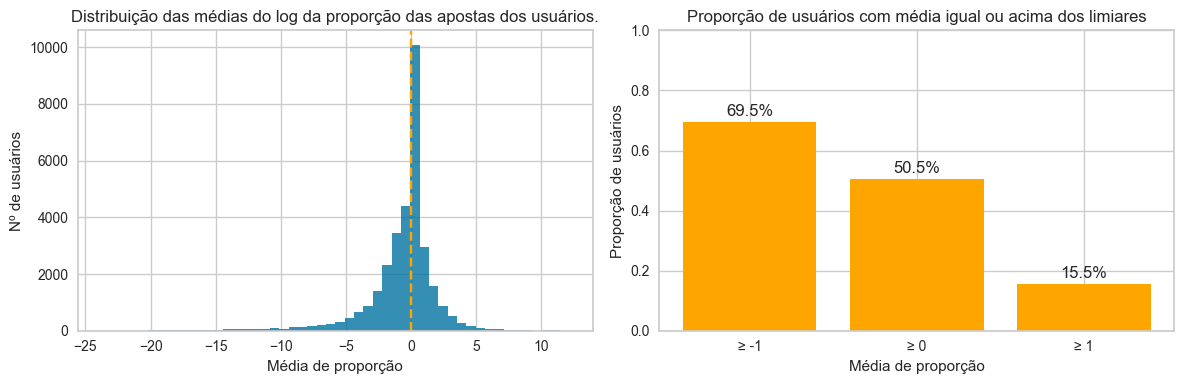

In [23]:
def plot_users_bet_analysis(df):
    u = df.groupby('user_id', observed=True).agg({
        'bets_log': 'mean'
    })
    amount = u['bets_log']
    thresholds = [-1 ,0, 1]
    props = [(amount >= t).mean() for t in thresholds]  # proporção >= limiar

    
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

   
    # p80 = amount.quantile(0.80)
    axs[0].hist(
        amount,
        bins=50,
        # range=(amount.min(), p80),
        alpha=0.8
    )
    axs[0].axvline(0, linestyle='--', color='orange')
    axs[0].set_title('Distribuição das médias do log da proporção das apostas dos usuários.')
    axs[0].set_xlabel('Média de proporção')
    axs[0].set_ylabel('Nº de usuários')

    
    labels = [f'≥ {t}' for t in thresholds]
    axs[1].bar(labels, props, color="orange")
    axs[1].set_ylim(0, 1)
    axs[1].set_title('Proporção de usuários com média igual ou acima dos limiares')
    axs[1].set_xlabel('Média de proporção')
    axs[1].set_ylabel('Proporção de usuários')
    for i, p in enumerate(props):
        axs[1].text(i, p + 0.02, f'{p*100:.1f}%', ha='center')

    plt.tight_layout()
    plt.savefig("figs/p5.pdf", dpi=300, bbox_inches="tight")
    plt.show()

plot_users_bet_analysis(bets)


In [21]:
bets.groupby('user_id', observed=True).agg({
        'bets_log': 'mean'
    }).sort_values('bets_log')


,bets_log
user_id,
1110442,-23.775702
1289444,-23.527487
249894,-22.919001
1268826,-22.621780
1405981,-22.567560
...,...
1181389,11.401729
1222718,11.618171
457296,12.028156


In [24]:
bets[bets['user_id']==5588]


,game_id,user_id,bet_id,fiat_bet_amount,fiat_profit_amount,date,odds_adjusted,user_bet_amount_proportion,bet_risk,odds_log,bets_log,hour,day_of_week,day_of_year,week_of_year
index,,,,,,,,,,,,,,,
86,2828659,5588,12159565,3.545083,-3.545083,2020-09-09 01:30:38,10.00,1.000000,2.515477,2.302585,0.000000,1,2,253,37
87,2828659,5588,12159555,3.545083,-3.545083,2020-09-09 01:30:38,2.00,1.000000,0.661082,0.693147,0.000000,1,2,253,37
88,2828659,5588,12159563,1.772542,1.701640,2020-09-09 01:30:38,1.96,0.500000,0.438143,0.672944,-0.693147,1,2,253,37
89,2828660,5588,12159602,14.180333,-14.180333,2020-09-09 01:30:55,2.00,4.020101,1.061848,0.693147,1.391307,1,2,253,37
90,2828661,5588,12159647,28.360666,-28.360666,2020-09-09 01:31:10,2.00,7.804497,1.252939,0.693147,2.054700,1,2,253,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5705,2899996,5588,15091779,1.282086,-1.282086,2020-09-30 07:09:36,2.00,0.061215,-0.143549,0.693147,-2.793370,7,2,274,40
5706,2899997,5588,15091836,0.641043,-0.641043,2020-09-30 07:10:00,10.00,0.030897,1.513902,2.302585,-3.477085,7,2,274,40
5707,2899997,5588,15091826,2.564173,2.564173,2020-09-30 07:10:00,2.00,0.124799,0.061635,0.693147,-2.081053,7,2,274,40


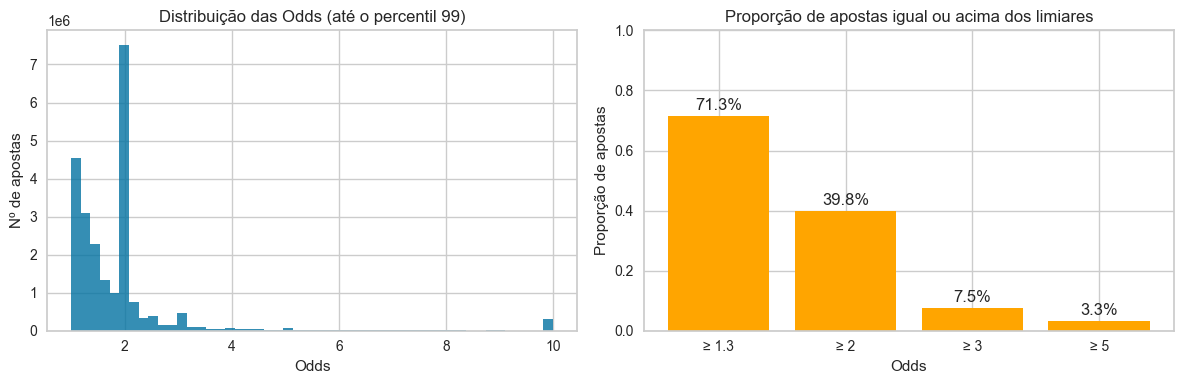

In [95]:
def plot_bets_odd_analysis(df):
    odds = df['odds_adjusted']
    thresholds = [1.3, 2, 3, 5]
    props = [(odds >= t).mean() for t in thresholds]  # proporção >= limiar

    
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

   
    p99 = odds.quantile(0.99)
    axs[0].hist(
        odds,
        bins=50,
        range=(odds.min(), p99),
        alpha=0.8
    )
    # axs[0].axvline(2, linestyle='--', color='orange')

    axs[0].set_title('Distribuição das Odds (até o percentil 99)')
    axs[0].set_xlabel('Odds')
    axs[0].set_ylabel('Nº de apostas')

    
    labels = [f'≥ {t}' for t in thresholds]
    axs[1].bar(labels, props, color="orange")
    axs[1].set_ylim(0, 1)
    axs[1].set_title('Proporção de apostas igual ou acima dos limiares')
    axs[1].set_ylabel('Proporção de apostas')
    axs[1].set_xlabel('Odds')
    
    for i, p in enumerate(props):
        axs[1].text(i, p + 0.02, f'{p*100:.1f}%', ha='center')

    plt.tight_layout()
    plt.savefig("figs/p1.pdf", dpi=300, bbox_inches="tight")
    plt.show()

plot_bets_odd_analysis(bets)


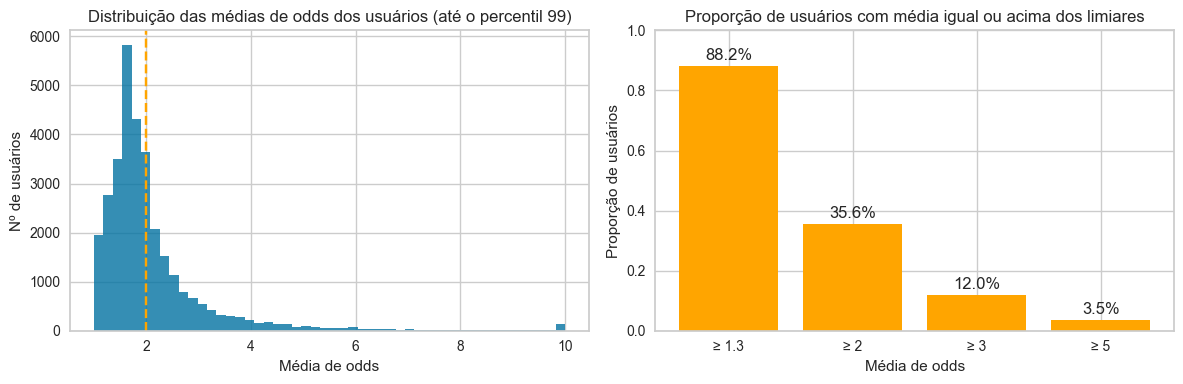

In [94]:
def plot_users_odd_analysis(df):
    u = df.groupby('user_id', observed=True).agg({
        'odds_adjusted': 'mean'
    })
    odds = u['odds_adjusted']
    thresholds = [1.3, 2, 3, 5]
    props = [(odds >= t).mean() for t in thresholds]  # proporção >= limiar

    
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

   
    p99 = odds.quantile(0.99)
    axs[0].hist(
        odds,
        bins=50,
        range=(odds.min(), p99),
        alpha=0.8
    )
    axs[0].axvline(2, linestyle='--', color='orange')
    axs[0].set_title('Distribuição das médias de odds dos usuários (até o percentil 99)')
    axs[0].set_xlabel('Média de odds')
    axs[0].set_ylabel('Nº de usuários')

    
    labels = [f'≥ {t}' for t in thresholds]
    axs[1].bar(labels, props, color="orange")
    axs[1].set_ylim(0, 1)
    axs[1].set_title('Proporção de usuários com média igual ou acima dos limiares')
    axs[1].set_xlabel('Média de odds')
    axs[1].set_ylabel('Proporção de usuários')
    for i, p in enumerate(props):
        axs[1].text(i, p + 0.02, f'{p*100:.1f}%', ha='center')

    plt.tight_layout()
    plt.savefig("figs/p2.pdf", dpi=300, bbox_inches="tight")
    plt.show()

plot_users_odd_analysis(df)


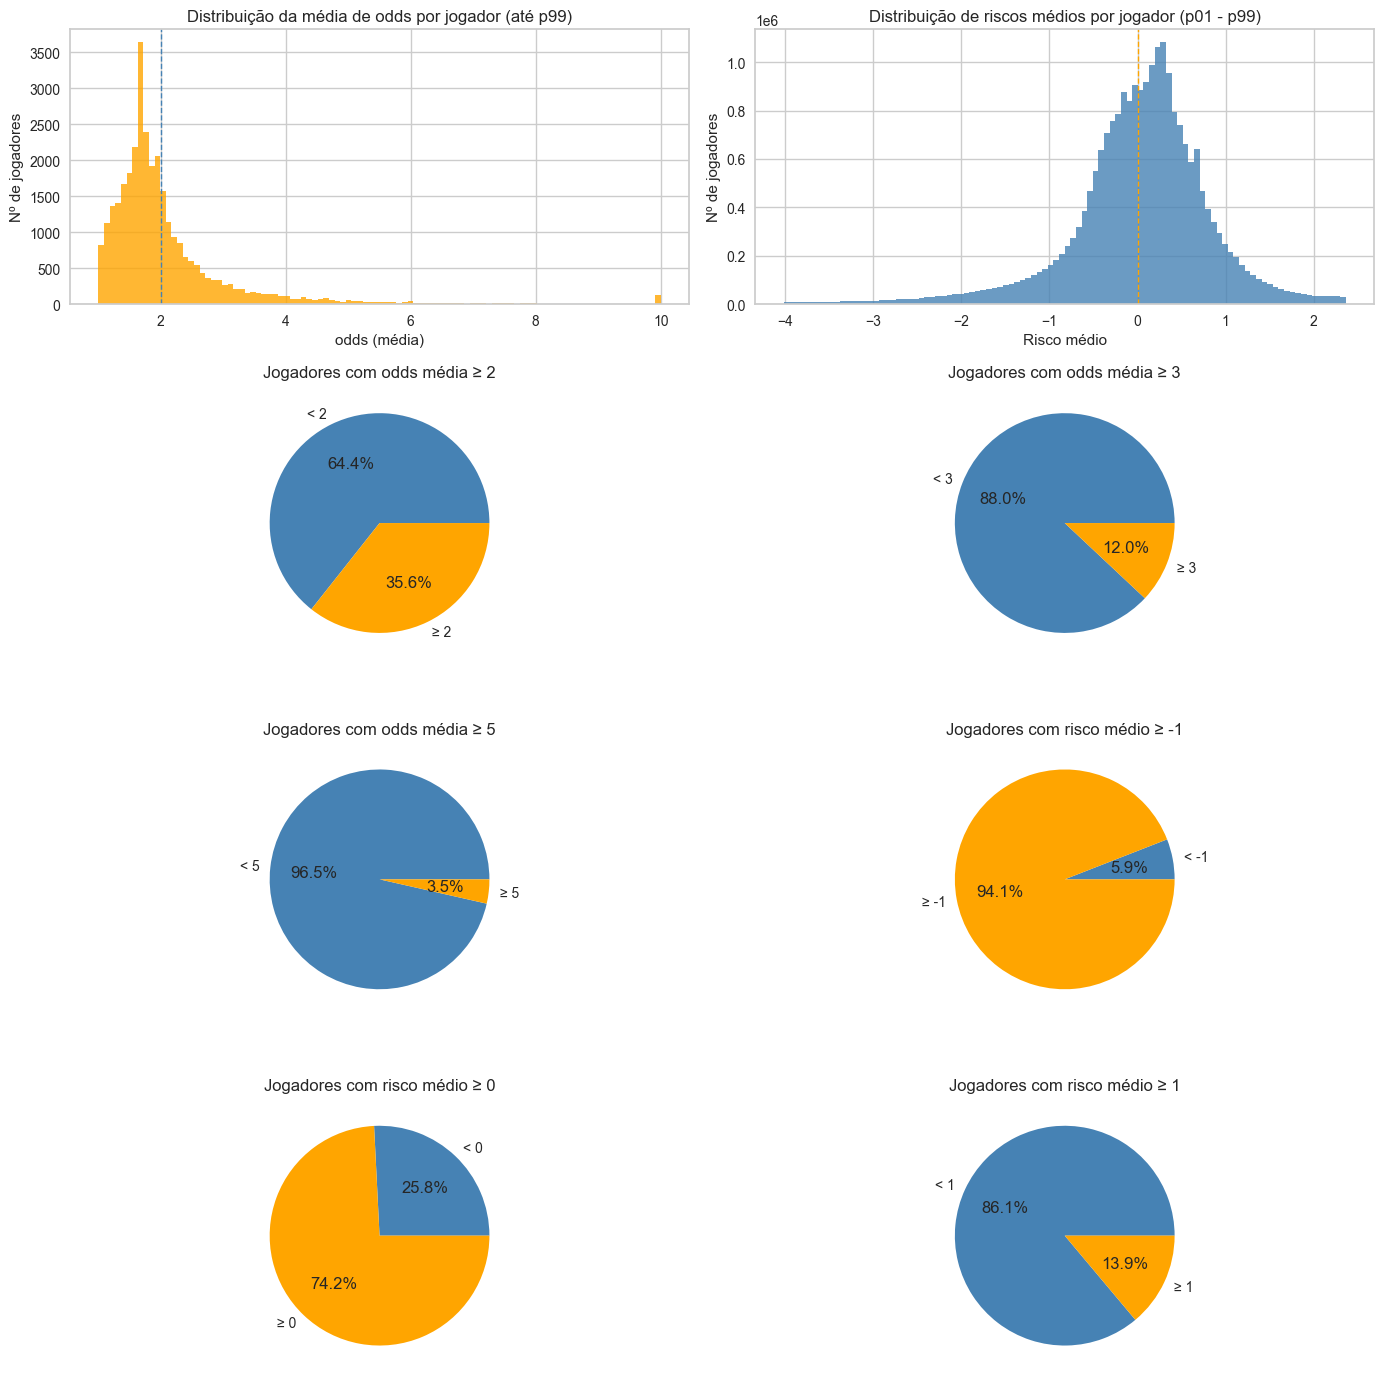

In [171]:
plot_users_dash(df)


In [ ]:
df.head()


,game_id,user_id,bet_id,fiat_bet_amount,fiat_profit_amount,date,odds_adjusted,user_bet_amount_proportion,bet_risk,odds_log,bets_log,hour,day_of_week,day_of_year,week_of_year
0,2831698,44,212042687,0.000034,0.000001,2020-09-09 22:51:14,1.03,1.000000,-0.103505,0.029559,0.000000,22,2,253,37
1,2831768,44,212067364,0.000034,0.000001,2020-09-09 23:26:45,1.03,1.000000,-0.103505,0.029559,0.000000,23,2,253,37
2,2831820,44,212085405,0.000034,0.000003,2020-09-09 23:48:26,1.08,1.000000,-0.048888,0.076961,0.000000,23,2,253,37
3,2832628,44,212376980,0.000035,0.000024,2020-09-10 05:36:11,1.67,1.039625,0.464507,0.512824,0.038860,5,3,254,37
4,2832686,44,212397916,0.000140,0.000140,2020-09-10 06:01:38,2.00,4.156854,1.071484,0.693147,1.424759,6,3,254,37


In [81]:
df.groupby('user_id', observed=True).agg({
        'bet_id': 'nunique'
    })


,bet_id
user_id,
44,83
46,3
5588,5490
5977,29
7612,1
...,...
1503508,6
1503513,6
1503516,3


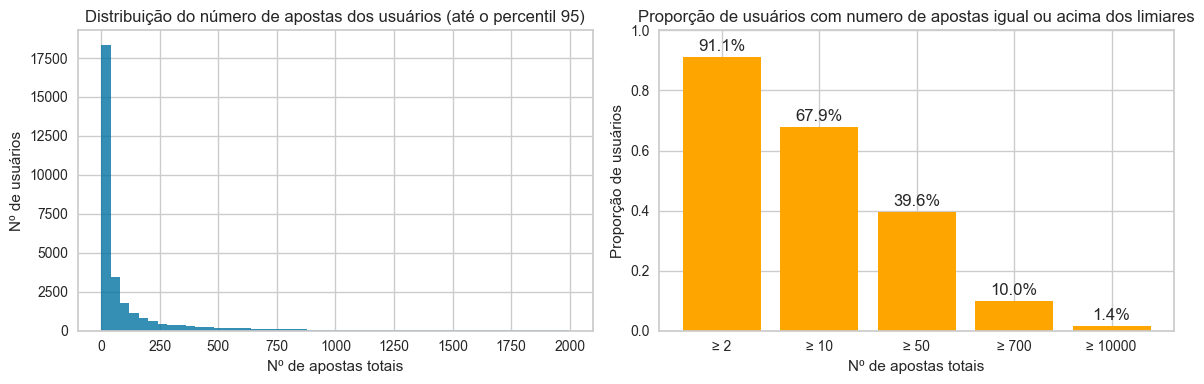

In [96]:
def plot_users_bet_count_analysis(df):
    u = df.groupby('user_id', observed=True).agg({
        'bet_id': 'nunique'
    })
    bets = u['bet_id']
    thresholds = [2, 10, 50, 700, 10000]
    props = [(bets >= t).mean() for t in thresholds]  # proporção >= limiar

    
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

   
    p95 = bets.quantile(0.95)
    axs[0].hist(
        bets,
        bins=50,
        range=(bets.min(), p95),
        alpha=0.8
    )
    # axs[0].axvline(2, linestyle='--', color='orange')
    axs[0].set_title('Distribuição do número de apostas dos usuários (até o percentil 95)')
    axs[0].set_xlabel('Nº de apostas totais')
    axs[0].set_ylabel('Nº de usuários')

    
    labels = [f'≥ {t}' for t in thresholds]
    axs[1].bar(labels, props, color="orange")
    axs[1].set_ylim(0, 1)
    axs[1].set_title('Proporção de usuários com numero de apostas igual ou acima dos limiares')
    axs[1].set_ylabel('Proporção de usuários')
    axs[1].set_xlabel('Nº de apostas totais')
    
    for i, p in enumerate(props):
        axs[1].text(i, p + 0.02, f'{p*100:.1f}%', ha='center')

    plt.tight_layout()
    plt.savefig("figs/p3.pdf", dpi=300, bbox_inches="tight")
    plt.show()

plot_users_bet_count_analysis(df)


In [172]:
df.head()


,game_id,user_id,bet_id,fiat_bet_amount,fiat_profit_amount,date,odds_adjusted,user_bet_amount_proportion,bet_risk,odds_log,bets_log,hour,day_of_week,day_of_year,week_of_year
0,2831698,44,212042687,0.000034,0.000001,2020-09-09 22:51:14,1.03,1.000000,-0.103505,0.029559,0.000000,22,2,253,37
1,2831768,44,212067364,0.000034,0.000001,2020-09-09 23:26:45,1.03,1.000000,-0.103505,0.029559,0.000000,23,2,253,37
2,2831820,44,212085405,0.000034,0.000003,2020-09-09 23:48:26,1.08,1.000000,-0.048888,0.076961,0.000000,23,2,253,37
3,2832628,44,212376980,0.000035,0.000024,2020-09-10 05:36:11,1.67,1.039625,0.464507,0.512824,0.038860,5,3,254,37
4,2832686,44,212397916,0.000140,0.000140,2020-09-10 06:01:38,2.00,4.156854,1.071484,0.693147,1.424759,6,3,254,37


In [27]:
bets.groupby(['user_id','day_of_year'], observed=True)['bet_id'].count().sort_values()


user_id  day_of_year
1503546  274               1
1322730  257               1
         260               1
1322769  254               1
1322781  256               1
                        ... 
369102   273            6848
368729   273            6848
1205760  273            6848
148419   262            7687
         263            8384
Name: bet_id, Length: 130644, dtype: int64

In [ ]:
# m24_odd = (df.groupby(['user_id','day_of_year','hour'], observed=True)['odds_adjusted']
#          .mean()
#          .unstack('hour', fill_value=0))
# m24_odd = m24_odd.reindex(columns=list(range(24)), fill_value=0)

m24_bet = (df.groupby(['user_id','day_of_year','hour'], observed=True)['user_bet_amount_proportion']
         .mean()
         .unstack('hour', fill_value=0))
m24_bet = m24_bet.reindex(columns=list(range(24)), fill_value=0)
m24_bet.head()


hour                  0    1    2    3    4         5        6    7    8   \
user_id day_of_year                                                         
44      253          0.0  0.0  0.0  0.0  0.0  0.000000  0.00000  0.0  0.0   
        254          0.0  0.0  0.0  0.0  0.0  1.039625  4.91754  0.0  0.0   
        255          0.0  0.0  0.0  0.0  0.0  0.000000  0.00000  0.0  0.0   
        257          0.0  0.0  0.0  0.0  0.0  0.000000  0.00000  0.0  0.0   
        259          0.0  0.0  0.0  0.0  0.0  0.000000  0.00000  0.0  0.0   

hour                  9   ...   14       15   16   17   18        19   20  \
user_id day_of_year       ...                                               
44      253          0.0  ...  0.0  0.00000  0.0  0.0  0.0  0.000000  0.0   
        254          0.0  ...  0.0  0.00000  0.0  0.0  0.0  0.000000  0.0   
        255          0.0  ...  0.0  0.93326  0.0  0.0  0.0  0.000000  0.0   
        257          0.0  ...  0.0  0.00000  0.0  0.0  0.0  0.957054  0.0   
        259          0.0  ...  0.0  0.00000  0.0  0.0  0.0  0.000000  0.0   

hour                  21        22   23  
user_id day_of_year                      
44      253          0.0  1.000000  1.0  
        254          0.0  0.000000  0.0  
        255          0.0  0.000000  0.0  
        257          0.0  0.000000  0.0  
        259          0.0  0.933912  0.0  

[5 rows x 24 columns]

In [61]:

m24_bet = m24_bet.div(m24_bet.sum(axis=1), axis=0)
m24_bet.head()


hour                  0    1    2    3    4         5         6    7    8   \
user_id day_of_year                                                          
44      253          0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0   
        254          0.0  0.0  0.0  0.0  0.0  0.174517  0.825483  0.0  0.0   
        255          0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0   
        257          0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0   
        259          0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0   

hour                  9   ...   14   15   16   17   18        19   20   21  \
user_id day_of_year       ...                                                
44      253          0.0  ...  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0   
        254          0.0  ...  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0   
        255          0.0  ...  0.0  1.0  0.0  0.0  0.0  0.000000  0.0  0.0   
        257          0.0  ...  0.0  0.0  0.0  0.0  0.0  0.217271  0.0  0.0   
        259          0.0  ...  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0   

hour                  22   23  
user_id day_of_year            
44      253          0.5  0.5  
        254          0.0  0.0  
        255          0.0  0.0  
        257          0.0  0.0  
        259          1.0  0.0  

[5 rows x 24 columns]

In [ ]:

# m24_odd = m24_odd.div(m24_odd.sum(axis=1), axis=0)
# m24_odd.head()


hour                  0    1    2    3    4         5         6    7    8   \
user_id day_of_year                                                          
44      253          0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0   
        254          0.0  0.0  0.0  0.0  0.0  0.484761  0.515239  0.0  0.0   
        255          0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0   
        257          0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0   
        259          0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.0   

hour                  9   ...   14   15   16   17   18        19   20   21  \
user_id day_of_year       ...                                                
44      253          0.0  ...  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0   
        254          0.0  ...  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0   
        255          0.0  ...  0.0  1.0  0.0  0.0  0.0  0.000000  0.0  0.0   
        257          0.0  ...  0.0  0.0  0.0  0.0  0.0  0.332258  0.0  0.0   
        259          0.0  ...  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0   

hour                       22        23  
user_id day_of_year                      
44      253          0.494005  0.505995  
        254          0.000000  0.000000  
        255          0.000000  0.000000  
        257          0.000000  0.000000  
        259          1.000000  0.000000  

[5 rows x 24 columns]

In [62]:
def agg_hours(hours,name):
    # min  = hours.min(axis=1).rename(f"{name}_min_hours%")
    max  = hours.max(axis=1).rename(f"{name}_top1hour%")
    # std  = hours.std(axis=1).rename(f"{name}_std_hours%")

    p = hours.to_numpy()
    top2 = np.sort(p, axis=1)[:, -2:]
    top2_sum = pd.Series(top2.sum(axis=1), index=hours.index, name=f"{name}_top2hours%")

    top4 = np.sort(p, axis=1)[:, -2:]
    top4_sum = pd.Series(top4.sum(axis=1), index=hours.index, name=f"{name}_top4hours%")

    uniform = 1.0 / 24.0
    mean_abs_dev_uniform = (
        hours.sub(uniform).abs().mean(axis=1).rename(f"{name}_mean_abs_dev_uniform%")
    )

    hour_features_daily = pd.concat(
        [
            # min,
            max,
            # std,
            top2_sum,
            top4_sum,
            # mean_abs_dev_uniform,
        ],
        axis=1,
    )
    return hour_features_daily


In [63]:
bet_hour_agg = agg_hours(m24_bet,'bet')
# odd_hour_agg = agg_hours(m24_odd,'odd')


In [64]:
bet_hour_agg


bet_top1hour%  bet_top2hours%  bet_top4hours%
user_id day_of_year                                               
44      253               0.500000        1.000000        1.000000
        254               0.825483        1.000000        1.000000
        255               1.000000        1.000000        1.000000
        257               0.559135        0.782729        0.782729
        259               1.000000        1.000000        1.000000
...                            ...             ...             ...
1503508 274               1.000000        1.000000        1.000000
1503513 274               1.000000        1.000000        1.000000
1503516 274               1.000000        1.000000        1.000000
1503542 274               1.000000        1.000000        1.000000
1503546 274               1.000000        1.000000        1.000000

[130644 rows x 3 columns]

In [68]:
n_hours = pd.Series((m24_bet != 0).sum(axis=1))
n_hours.name = 'n_active_hours'
n_hours.head()


user_id  day_of_year
44       253            2
         254            2
         255            1
         257            3
         259            1
Name: n_active_hours, dtype: int64

In [66]:
df['gap_min'] = df.groupby('user_id')['date'].diff().dt.total_seconds().div(60)
threshold_min = 60
df['new_session'] = df['gap_min'].isna() | (df['gap_min'] > threshold_min)
df['session_id'] = df.groupby('user_id')['new_session'].cumsum().astype('int64')
df.drop(columns=['gap_min','new_session'], inplace=True)
df.head()


,game_id,user_id,bet_id,fiat_bet_amount,fiat_profit_amount,date,odds_adjusted,user_bet_amount_proportion,odds_log,bets_log,hour,day_of_week,day_of_year,week_of_year,session_id
0,2831698,44,212042687,0.000034,0.000001,2020-09-09 22:51:14,1.03,1.000000,0.029559,0.000000,22,2,253,37,1
1,2831768,44,212067364,0.000034,0.000001,2020-09-09 23:26:45,1.03,1.000000,0.029559,0.000000,23,2,253,37,1
2,2831820,44,212085405,0.000034,0.000003,2020-09-09 23:48:26,1.08,1.000000,0.076961,0.000000,23,2,253,37,1
3,2832628,44,212376980,0.000035,0.000024,2020-09-10 05:36:11,1.67,1.039625,0.512824,0.038860,5,3,254,37,2
4,2832686,44,212397916,0.000140,0.000140,2020-09-10 06:01:38,2.00,4.156854,0.693147,1.424759,6,3,254,37,2


In [67]:

basic = (df.groupby(['user_id','day_of_year'], observed=True)
           .agg(
               odds_log_mean=('odds_log','mean'),
               odds_log_std=('odds_log','std'),
               
               bet_prop_log_mean=('bets_log','mean'),
               bet_prop_log_std=('bets_log','std'),
               
               
               n_bets=('bet_id','size'),
            #    bet_sum=('fiat_bet_amount','sum'),
            #    profit_sum=('fiat_profit_amount','sum'),
               n_sessions=('session_id','nunique'),
           )
           .fillna(0.0)
           .astype('float32'))

basic.head()


odds_log_mean  odds_log_std  bet_prop_log_mean  \
user_id day_of_year                                                   
44      253               0.045360      0.027368           0.000000   
        254               0.537515      0.259239           1.242422   
        255               0.029559      0.000000          -0.069071   
        257               0.036531      0.027343           0.324303   
        259               0.095418      0.104053          -0.068377   

                     bet_prop_log_std  n_bets  n_sessions  
user_id day_of_year                                        
44      253                  0.000000     3.0         1.0  
        254                  0.736760     5.0         1.0  
        255                  0.000000     1.0         1.0  
        257                  0.698184     4.0         3.0  
        259                  0.002970    15.0         1.0

In [69]:
hours = np.arange(24)

def slope(grp, column):
    y = (grp.groupby('hour')[column]
            .sum()
            .reindex(range(24), fill_value=0)
            .values)
    return float(linregress(hours, y).slope)

slope_bet = (
    df
    .groupby(['user_id','day_of_year'], observed=True)
    .apply(lambda g: slope(g, column='bets_log'))
    .rename('slope_bet')
)

slope_odd = (
    df
    .groupby(['user_id','day_of_year'], observed=True)
    .apply(lambda g: slope(g, column='odds_log'))
    .rename('slope_odd')
)


In [70]:
slope_bet.name = 'slope_bet_day'
slope_odd.name = 'slope_odd_day'


In [71]:
slope_bet.sort_values(ascending=False)


user_id  day_of_year
967686   273            111.463481
146999   258            109.099027
965030   256             96.408246
1407054  262             93.239670
673274   273             90.372611
                           ...    
368729   258            -90.542799
1343144  262            -94.806811
1443590  264            -98.237443
1345362  254           -103.246936
220550   266           -104.571685
Name: slope_bet_day, Length: 130644, dtype: float64

In [72]:
daily_features = (
    basic
    .join(n_hours)
    .join(bet_hour_agg)
    # .join(odd_hour_agg)
    .join(slope_bet)
    .join(slope_odd)
    .reset_index()
)


In [73]:
past_bets = daily_features.groupby("user_id")["n_bets"].shift(1)

daily_features["user_daily_bet"] = (
    past_bets
    .groupby(daily_features["user_id"])
    .transform(lambda s: s.ewm(alpha=0.1, adjust=False).mean())
)
daily_features["user_daily_bet"] = daily_features["user_daily_bet"].fillna(
    daily_features.groupby("user_id")["n_bets"].transform("first")
)

daily_features["n_bet_proportion"] = daily_features["n_bets"] / daily_features["user_daily_bet"]
daily_features.drop(columns=['user_daily_bet','n_bets'], inplace=True)
daily_features.head()


,user_id,day_of_year,odds_log_mean,odds_log_std,bet_prop_log_mean,bet_prop_log_std,n_sessions,n_active_hours,bet_top1hour%,bet_top2hours%,bet_top4hours%,slope_bet_day,slope_odd_day,n_bet_proportion
0,44,253,0.045360,0.027368,0.000000,0.000000,1.0,2,0.500000,1.000000,1.000000,0.000000,0.001335,1.000000
1,44,254,0.537515,0.259239,1.242422,0.736760,1.0,2,0.825483,1.000000,1.000000,-0.029744,-0.013300,1.666667
2,44,255,0.029559,0.000000,-0.069071,0.000000,1.0,1,1.000000,1.000000,1.000000,-0.000210,0.000090,0.312500
3,44,257,0.036531,0.027343,0.324303,0.698184,3.0,3,0.559135,0.782729,0.782729,0.001503,0.000293,1.342282
4,44,259,0.095418,0.104053,-0.068377,0.002970,1.0,1,1.000000,1.000000,1.000000,-0.009365,0.013068,4.866970


In [74]:
daily_features = downcast_df(daily_features)
daily_features.head()


,user_id,day_of_year,odds_log_mean,odds_log_std,bet_prop_log_mean,bet_prop_log_std,n_sessions,n_active_hours,bet_top1hour%,bet_top2hours%,bet_top4hours%,slope_bet_day,slope_odd_day,n_bet_proportion
0,44,253,0.045360,0.027368,0.000000,0.000000,1.0,2,0.500000,1.000000,1.000000,0.000000,0.001335,1.000000
1,44,254,0.537515,0.259239,1.242422,0.736760,1.0,2,0.825483,1.000000,1.000000,-0.029744,-0.013300,1.666667
2,44,255,0.029559,0.000000,-0.069071,0.000000,1.0,1,1.000000,1.000000,1.000000,-0.000210,0.000090,0.312500
3,44,257,0.036531,0.027343,0.324303,0.698184,3.0,3,0.559135,0.782729,0.782729,0.001503,0.000293,1.342282
4,44,259,0.095418,0.104053,-0.068377,0.002970,1.0,1,1.000000,1.000000,1.000000,-0.009365,0.013068,4.866970


In [75]:
daily_features.columns


Index(['user_id', 'day_of_year', 'odds_log_mean', 'odds_log_std',
       'bet_prop_log_mean', 'bet_prop_log_std', 'n_sessions', 'n_active_hours',
       'bet_top1hour%', 'bet_top2hours%', 'bet_top4hours%', 'slope_bet_day',
       'slope_odd_day', 'n_bet_proportion'],
      dtype='object')

In [ ]:
len(daily_features)


130644

In [76]:
def rolling_user_aggregates(df, cols, windows):
    users = df['user_id'].drop_duplicates().reset_index(drop=True)
    result = pd.DataFrame({'user_id': users}).set_index('user_id')

    for col in cols:
        col_values = []
        col_stds = []
        for user_id, group in df.groupby('user_id'):
            arr = group[col].values
            mean_agg = [pd.Series(arr).rolling(window=w, min_periods=1).mean().iloc[-1] for w in windows]
            std_agg = [pd.Series(arr).rolling(window=w, min_periods=1).std(ddof=0).iloc[-1] for w in windows]
            col_values.append(mean_agg)
            col_stds.append(std_agg)
        col_values = np.array(col_values)
        col_stds = np.array(col_stds)
        for idx, window in enumerate(windows):
            result[f"{col}_mean_{window}d"] = col_values[:, idx]
            result[f"{col}_std_{window}d"] = col_stds[:, idx]

    result = result.reset_index()
    return result


In [77]:
features = [col for col in daily_features.columns if col not in ('user_id', 'day_of_year')]
users = rolling_user_aggregates(
    daily_features,
    features,
    windows=[2, 7, 14, 21] # from 30 to 21
)


In [78]:
users.head()


,user_id,odds_log_mean_mean_2d,odds_log_mean_std_2d,odds_log_mean_mean_7d,odds_log_mean_std_7d,odds_log_mean_mean_14d,odds_log_mean_std_14d,odds_log_mean_mean_21d,odds_log_mean_std_21d,odds_log_std_mean_2d,...,slope_odd_day_mean_21d,slope_odd_day_std_21d,n_bet_proportion_mean_2d,n_bet_proportion_std_2d,n_bet_proportion_mean_7d,n_bet_proportion_std_7d,n_bet_proportion_mean_14d,n_bet_proportion_std_14d,n_bet_proportion_mean_21d,n_bet_proportion_std_21d
0,44,0.055120,0.012787,0.131939,0.097646,0.138996,0.146927,0.138996,0.146927,0.050967,...,-0.002414,0.008597,1.282375,0.436275,1.576553,0.677132,1.685357,1.150637,1.685357,1.150637
1,46,0.349807,0.000000,0.349807,0.000000,0.349807,0.000000,0.349807,0.000000,0.588818,...,-0.010494,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
2,5588,1.072452,0.018466,0.944114,0.111931,0.983297,0.267010,0.962997,0.233023,0.689501,...,-0.527213,1.287427,1.118203,0.376017,0.802359,0.566608,0.648897,0.588042,0.708415,0.562243
3,5977,0.463704,0.074879,0.824962,0.870706,0.731960,0.750704,0.731960,0.750704,0.375826,...,0.000213,0.009778,5.492139,3.419127,2.736390,2.587291,2.215473,2.306298,2.215473,2.306298
4,7612,0.165514,0.000000,0.165514,0.000000,0.165514,0.000000,0.165514,0.000000,0.000000,...,-0.001655,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000


In [ ]:
def plot_users_bet_analysis(df):
    u = df.groupby('user_id', observed=True).agg({
        'bets_log': 'mean'
    })
    amount = u['bets_log']
    thresholds = [-1 ,0, 1]
    props = [(amount >= t).mean() for t in thresholds]  # proporção >= limiar

    
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

   
    # p80 = amount.quantile(0.80)
    axs[0].hist(
        amount,
        bins=50,
        # range=(amount.min(), p80),
        alpha=0.8
    )
    axs[0].axvline(0, linestyle='--', color='orange')
    axs[0].set_title('Distribuição das médias do log da proporção das apostas dos usuários.')
    axs[0].set_xlabel('Média de proporção')
    axs[0].set_ylabel('Nº de usuários')

    
    labels = [f'≥ {t}' for t in thresholds]
    axs[1].bar(labels, props, color="orange")
    axs[1].set_ylim(0, 1)
    axs[1].set_title('Proporção de usuários com média igual ou acima dos limiares')
    axs[1].set_xlabel('Média de proporção')
    axs[1].set_ylabel('Proporção de usuários')
    for i, p in enumerate(props):
        axs[1].text(i, p + 0.02, f'{p*100:.1f}%', ha='center')

    plt.tight_layout()
    plt.savefig("figs/p6.pdf", dpi=300, bbox_inches="tight")
    plt.show()

plot_users_bet_analysis(bets)


In [79]:
users.to_parquet('data/users.parquet',engine='fastparquet')
daily_features.to_parquet('data/daily.parquet',engine='fastparquet')
 


In [3]:

users = pd.read_parquet('data/users.parquet',engine='fastparquet')
daily_features = pd.read_parquet('data/daily.parquet',engine='fastparquet')


In [4]:
users.head()


,user_id,odds_log_mean_mean_2d,odds_log_mean_std_2d,odds_log_mean_mean_7d,odds_log_mean_std_7d,odds_log_mean_mean_14d,odds_log_mean_std_14d,odds_log_mean_mean_21d,odds_log_mean_std_21d,odds_log_std_mean_2d,...,slope_odd_day_mean_21d,slope_odd_day_std_21d,n_bet_proportion_mean_2d,n_bet_proportion_std_2d,n_bet_proportion_mean_7d,n_bet_proportion_std_7d,n_bet_proportion_mean_14d,n_bet_proportion_std_14d,n_bet_proportion_mean_21d,n_bet_proportion_std_21d
0,44,0.055120,0.012787,0.131939,0.097646,0.138996,0.146927,0.138996,0.146927,0.050967,...,-0.002414,0.008597,1.282375,0.436275,1.576553,0.677132,1.685357,1.150637,1.685357,1.150637
1,46,0.349807,0.000000,0.349807,0.000000,0.349807,0.000000,0.349807,0.000000,0.588818,...,-0.010494,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
2,5588,1.072452,0.018466,0.944114,0.111931,0.983297,0.267010,0.962997,0.233023,0.689501,...,-0.527213,1.287427,1.118203,0.376017,0.802359,0.566608,0.648897,0.588042,0.708415,0.562243
3,5977,0.463704,0.074879,0.824962,0.870706,0.731960,0.750704,0.731960,0.750704,0.375826,...,0.000213,0.009778,5.492139,3.419127,2.736390,2.587291,2.215473,2.306298,2.215473,2.306298
4,7612,0.165514,0.000000,0.165514,0.000000,0.165514,0.000000,0.165514,0.000000,0.000000,...,-0.001655,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000


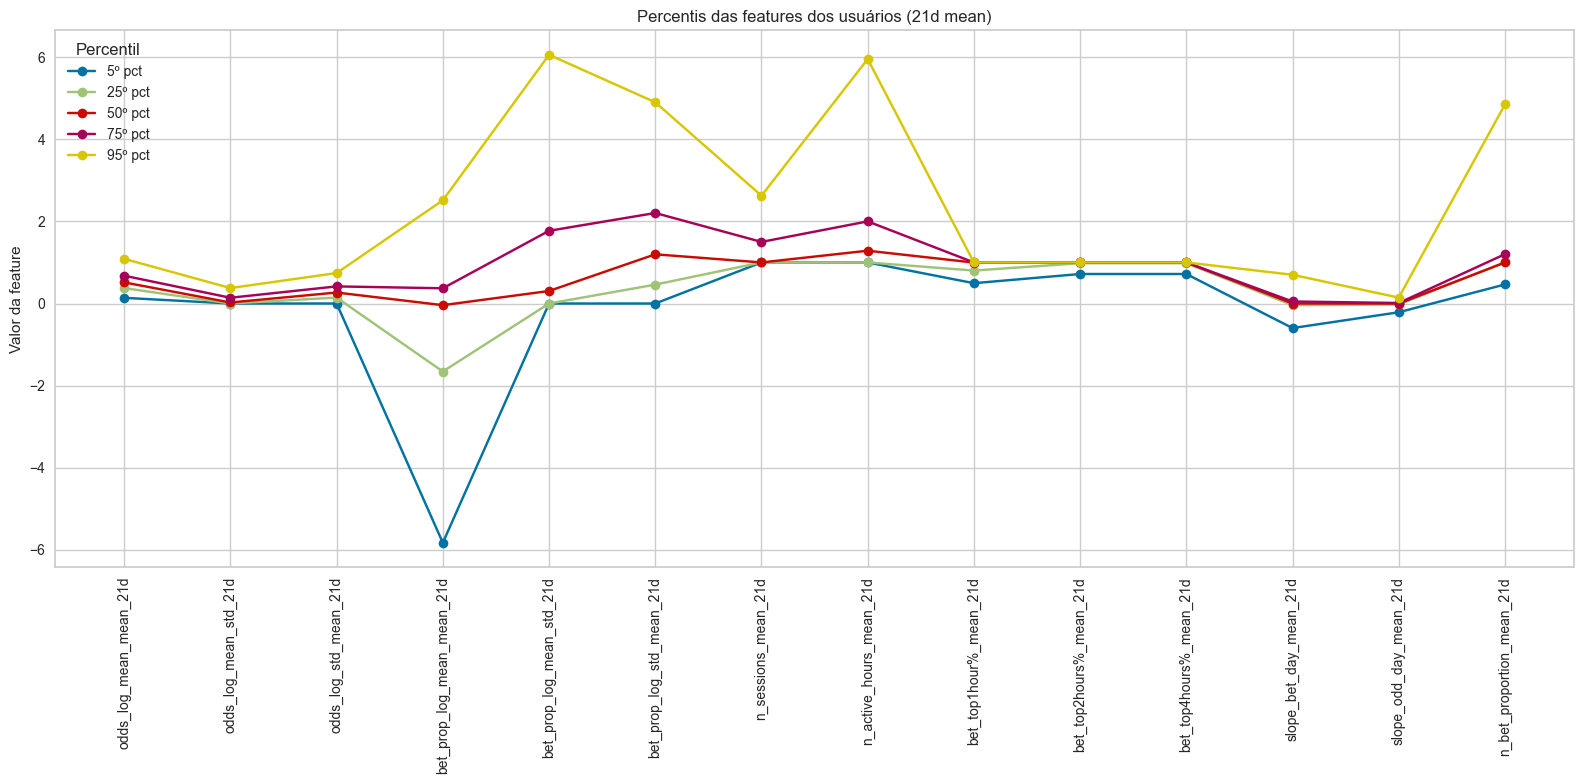

In [158]:
columns = [column for column in users.columns if ('21d' in column and 'mean' in column)]

percentis = [5, 25, 50, 75, 95]
summary = []
for col in columns:
    percentiles_values = np.percentile(users[col].dropna(), percentis)
    summary.append(percentiles_values)

summary = np.array(summary)

plt.figure(figsize=(16, 8))
for i, perc in enumerate(percentis):
    plt.plot(columns, summary[:, i], marker='o', label=f'{perc}º pct')

plt.xticks(rotation=90)
plt.title("Percentis das features dos usuários (21d mean)")
plt.ylabel("Valor da feature")
plt.legend(title="Percentil")
plt.tight_layout()
plt.show()



In [5]:
features = [col for col in users.columns if col != 'user_id']

X = users[features]


In [ ]:
X.shape


(32102, 96)

In [ ]:
def clip_outliers(df, lower_q=0.001, upper_q=0.999):
    df = df.copy()
    for col in df.columns:
        lo, hi = df[col].quantile([lower_q, upper_q])
        df[col] = df[col].clip(lo, hi)
    return df


In [167]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_scaled[0]


array([-1.417196  ,  0.08072803, -1.25927451,  0.57238837, -1.24364996,
        0.88521869, -1.24443841,  0.87329572, -0.69970066,  0.09679649,
       -0.46352059,  0.86353002, -0.5565184 ,  0.75807838, -0.55798866,
        0.74911929, -2.76526875,  0.37825598, -1.00890095,  2.04253623,
       -0.53311061,  1.56106888, -0.53771379,  1.54067616, -0.14928049,
        0.92084729,  0.46353007,  1.4308405 ,  0.04778366,  1.28375453,
        0.0448013 ,  1.26616712,  1.        ,  0.5       ,  0.85714286,
        1.04978132,  0.83333333,  1.35784756,  0.83333333,  1.35784756,
        0.5       ,  1.        ,  0.42857143,  0.96076892,  0.46428571,
        0.9021098 ,  0.46428571,  0.9021098 , -0.22103075,  1.04160398,
       -0.13737613,  0.27765319, -0.53974828,  1.06089776, -0.53826371,
        1.04684571,  0.        ,  0.        , -0.20285204,  2.92484243,
       -1.07553258,  5.48552383, -1.04572671,  4.93841353,  0.        ,
        0.        , -0.20285204,  2.92484243, -1.07553258,  5.48

In [ ]:

# X_cliped = clip_outliers(pd.DataFrame(X_scaled))


In [169]:
pca = PCA(n_components=0.98, random_state=42)
Xr = pca.fit_transform(X_scaled)
Xr = pd.DataFrame(Xr)

# Para saber quanta variância cada coluna (componente) explica:
explained_variance_ratio = pca.explained_variance_ratio_
print("Variância explicada por componente:", explained_variance_ratio)
print("Variância explicada acumulada:", explained_variance_ratio.cumsum())


Variância explicada por componente: [0.48699717 0.26796841 0.07735334 0.04425964 0.03416122 0.01967135
 0.01363872 0.01111672 0.00932791 0.00750913 0.00623509 0.00386023]
Variância explicada acumulada: [0.48699717 0.75496558 0.83231892 0.87657856 0.91073978 0.93041112
 0.94404985 0.95516657 0.96449448 0.97200361 0.9782387  0.98209893]


In [170]:
len(Xr)


32102

In [171]:
def plot_pca(X: pd.DataFrame, dim: int = 3, save_path: str = None) -> None:
    """
    Plota X reduzido de acordo com a dimensão especificada usando matplotlib.
    - Se dim==2: scatterplot x/y
    - Se dim==3 and >=3 cols: scatter3d x/y/z
    - Se dim==4 and >=4 cols: scatter3d x/y/z, color=a (azul-laranja)
    - Se dim==5 and >=5 cols: scatter3d x/y/z, color=a (5a dimensão ignorada mas avisada, azul-laranja)
    Pode salvar com save_path (.pdf, .png, etc)
    """

    if dim < 2 or dim > 5:
        print("Apenas dim=2,3,4,5 são suportadas.")
        return
    if X.shape[1] < dim:
        print(f"Seu DataFrame tem apenas {X.shape[1]} colunas. Precisa de pelo menos {dim}.")
        return

    # Colormap azul-laranja
    azul_laranja = 'coolwarm'  # ou plt.cm.coolwarm

    # Usa os nomes das colunas como estão (original)
    columns = X.columns

    if dim == 2:
        plt.figure(figsize=(8,6))
        plt.scatter(X.iloc[:,0], X.iloc[:,1], s=10, alpha=0.2, c="blue")
        plt.xlabel(columns[0])
        plt.ylabel(columns[1])
        plt.title("PCA 2D")
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
        plt.show()
    elif dim == 3:
        fig = plt.figure(figsize=(10,8))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2], s=4, alpha=0.2, c="blue")
        ax.set_xlabel(columns[0])
        ax.set_ylabel(columns[1])
        ax.set_zlabel(columns[2])
        plt.title("PCA 3D")
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
        plt.show()
    elif dim == 4:
        fig = plt.figure(figsize=(10,8))
        ax = fig.add_subplot(111, projection='3d')
        p = ax.scatter(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2], 
                       c=X.iloc[:,3], cmap=azul_laranja, s=10, alpha=0.6)
        ax.set_xlabel(columns[0])
        ax.set_ylabel(columns[1])
        ax.set_zlabel(columns[2])
        plt.title("Distribuição de usuários após o PCA - melhores 4 dimensões (.88)")
        cbar = plt.colorbar(p, pad=0.1)
        cbar.set_label(columns[3])
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
        plt.show()
    elif dim == 5:
        fig = plt.figure(figsize=(10,8))
        ax = fig.add_subplot(111, projection='3d')
        p = ax.scatter(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2], 
                       c=X.iloc[:,3], cmap=azul_laranja, s=6, alpha=0.6)
        ax.set_xlabel(columns[0])
        ax.set_ylabel(columns[1])
        ax.set_zlabel(columns[2])
        plt.title("PCA 5D (mostrando 3 primeiras e cor = 4ª dimensão, azul-laranja)\n5ª dimensão não visualizada")
        cbar = plt.colorbar(p, pad=0.1)
        cbar.set_label(columns[3])
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
        plt.show()
        print(f"Atenção: Só mostrando as 3 primeiras dimensões + cor=4ª.\nA 5ª dimensão ({columns[4]}) não está no plot.")


In [ ]:
# plot_pca(X,4)


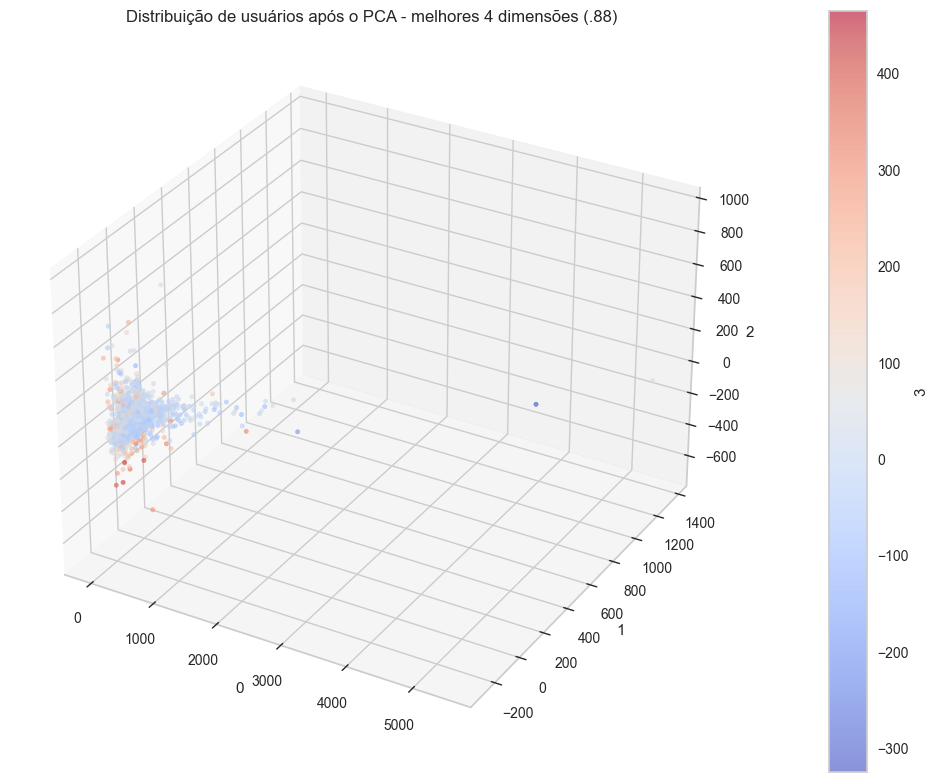

In [173]:
plot_pca(Xr,4)


In [174]:
clipped_X = clip_outliers(Xr)


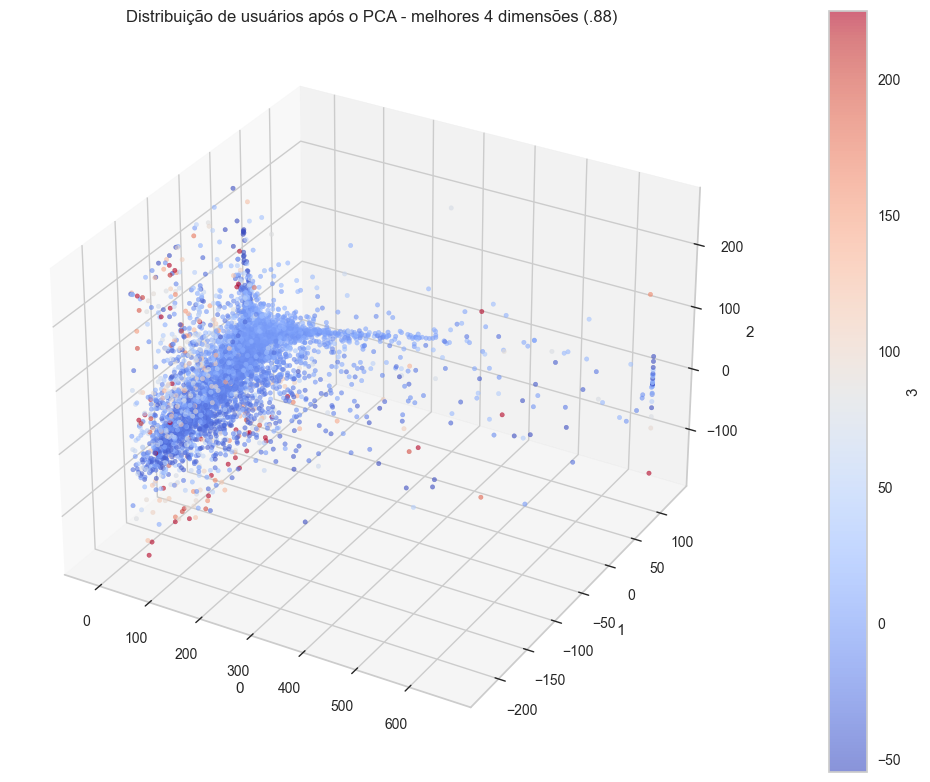

In [176]:
plot_pca(clipped_X,4,'figs/p4.pdf')


In [177]:
#pycaret
s = setup(data=clipped_X, session_id=123)


,Description,Value
0,Session id,123
1,Original data shape,"(32102, 12)"
2,Transformed data shape,"(32102, 12)"
3,Numeric features,12
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,CPU Jobs,-1
9,Use GPU,False


In [178]:
best = create_model("kmeans", num_clusters = 6)
results = pull()


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.6681,14012.4735,1.1189,0,0,0


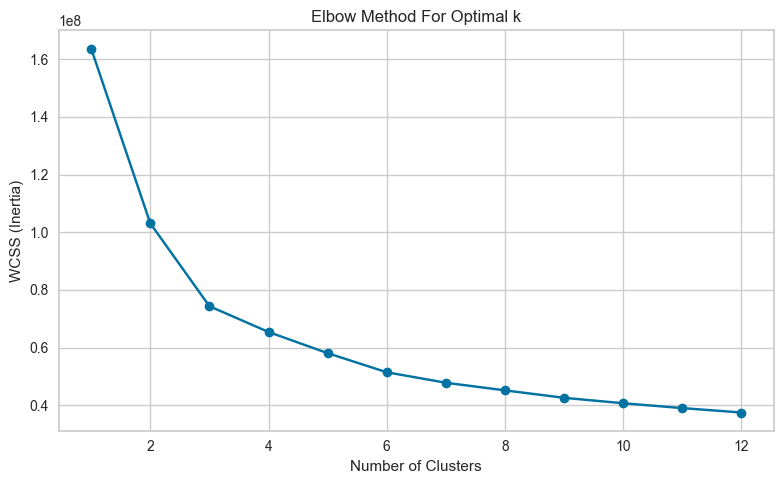

In [179]:
# Replot elbow manually using matplotlib and save as PDF


wcss = []
max_clusters = 12
for k in range(1, max_clusters+1):
    kmeans = KMeans(n_clusters=k, random_state=123, n_init=10)
    kmeans.fit(clipped_X)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(1, max_clusters+1), wcss, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS (Inertia)")
plt.title("Elbow Method For Optimal k")
plt.grid(True)
plt.tight_layout()
plt.savefig('figs/elbow.pdf')
plt.show()


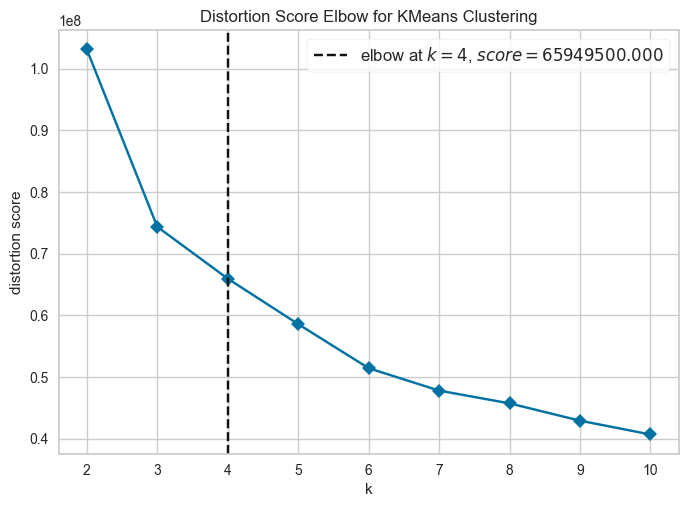

In [180]:
plot_model(best, plot="elbow")        
# plot_model(best, plot="silhouette")   
# plot_model(best, plot="cluster")


In [181]:
clustered = assign_model(best)
clustered["cluster"] = (
    clustered["Cluster"]
    .str.replace("Cluster ", "", regex=False)
    .astype(int)
)
labels = clustered["cluster"].values
clustered.drop(columns=['Cluster'], inplace=True)


In [182]:
clustered.head()


,0,1,2,3,4,5,6,7,8,9,10,11,cluster
0,-4.905762,14.141614,-0.845419,0.182065,0.972230,0.936042,1.450776,-1.044467,-1.630441,0.400226,1.097857,-0.834949,0
1,-13.523726,19.924870,-1.230719,-0.417248,0.639324,-1.008752,0.028840,1.289796,-0.113899,-0.853972,-0.289806,-0.997594,0
2,23.454065,-140.326614,15.659640,-9.601277,-7.104962,-24.064789,19.156023,14.800500,19.162292,-9.282497,0.487050,-0.529526,1
3,9.293743,10.803143,-2.768706,-1.837284,-12.997910,2.087838,1.087527,1.231423,1.322925,-0.723120,0.137399,4.771904,0
4,-13.519648,19.991106,0.629316,-1.295941,0.437572,0.053499,0.008554,0.485697,0.505413,-0.712946,-0.273381,-0.950951,0


In [183]:
pd.Series(labels).value_counts().sort_index()


0    25746
1     1957
2      413
3     3442
4      456
5       88
Name: count, dtype: int64

In [184]:
def plot_results2(
    X: pd.DataFrame,
    dim: int = 3,
    category_col: str = "cluster",
    save_path: str = None
) -> None:
    """
    Plota X (as 2D or 3D) com clusters coloridos usando matplotlib.
    Permite salvar o gráfico via save_path.
    """

    cols = [c for c in X.columns if c != category_col]
    X_plot = X.copy()

    X_plot[category_col] = X_plot[category_col].astype(str)
    clusters = sorted(X_plot[category_col].unique(), key=lambda v: int(v) if v.lstrip("-").isdigit() else v)


    def get_cluster_colormap(clusters):
        palette = plt.cm.Set1.colors  # até 9 cores, repete depois
        color_map = {}
        palette_i = 0
        for c in clusters:
            if c == "-1":
                color_map[c] = "gray"
            else:
                color_map[c] = palette[palette_i % len(palette)]
                palette_i += 1
        return color_map

    color_map = get_cluster_colormap(clusters)

    plt.figure(figsize=(10, 8) if dim == 3 else (8,6))

    if dim == 2:
        for c in clusters:
            ix = X_plot[category_col] == c
            plt.scatter(
                X_plot.loc[ix, cols[0]], X_plot.loc[ix, cols[1]],
                color=color_map[c], label=f"Cluster {c}",
                alpha=0.6, s=6
            )
        plt.xlabel(cols[0])
        plt.ylabel(cols[1])
        plt.title("PCA 2D")
        plt.legend()
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
        plt.show()
    elif dim == 3:
        fig = plt.figure(figsize=(12,10))
        ax = fig.add_subplot(111, projection='3d')
        for c in clusters:
            ix = X_plot[category_col] == c
            ax.scatter(
                X_plot.loc[ix, cols[0]], X_plot.loc[ix, cols[1]], X_plot.loc[ix, cols[2]],
                color=color_map[c],
                label=f"Cluster {c}",
                alpha=0.6, s=10
            )
        ax.set_xlabel(cols[0])
        ax.set_ylabel(cols[1])
        ax.set_zlabel(cols[2])
        ax.set_title("Distribuição dos clusters de usuários - melhores 3 dimensões")
        ax.legend()
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
        plt.show()
    else:
        print("Apenas dim=2 ou 3 são suportadas nesta função.")



<Figure size 1000x800 with 0 Axes>

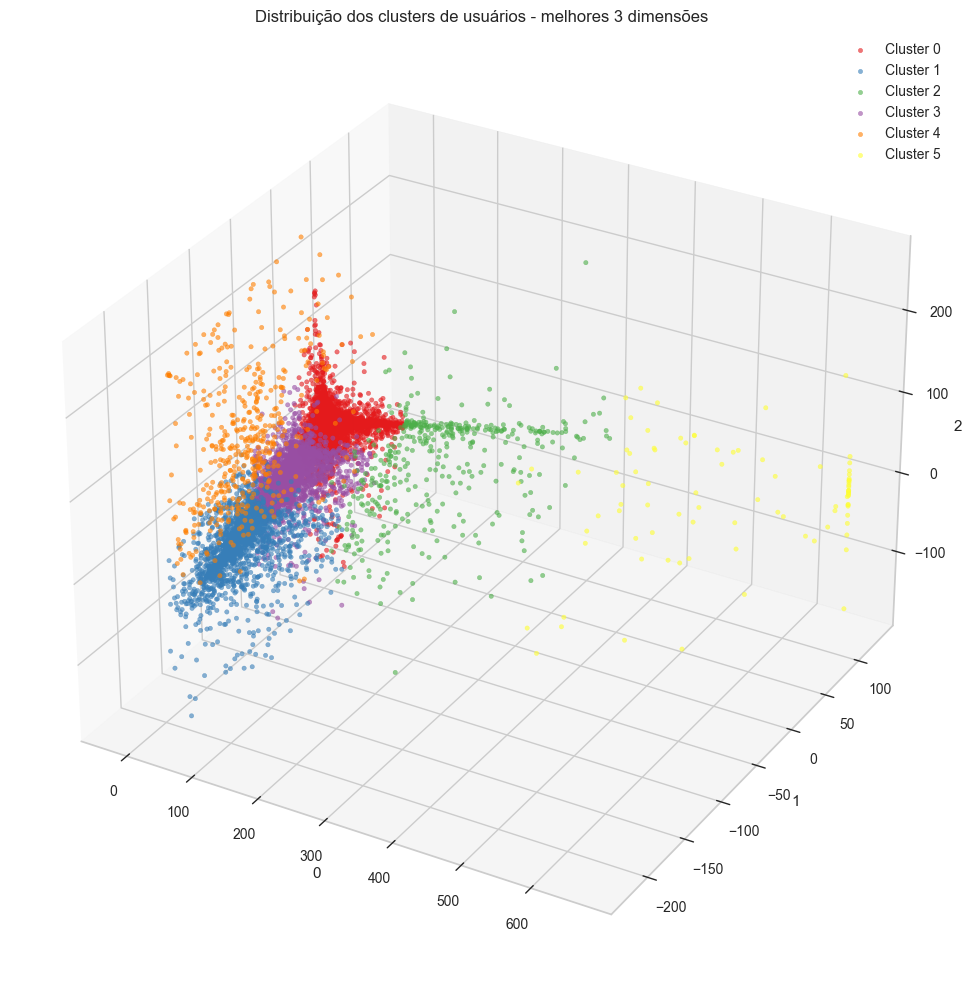

In [185]:
plot_results2(clustered,save_path='figs/p5.pdf')


In [186]:
users.columns


Index(['user_id', 'odds_log_mean_mean_2d', 'odds_log_mean_std_2d',
       'odds_log_mean_mean_7d', 'odds_log_mean_std_7d',
       'odds_log_mean_mean_14d', 'odds_log_mean_std_14d',
       'odds_log_mean_mean_21d', 'odds_log_mean_std_21d',
       'odds_log_std_mean_2d', 'odds_log_std_std_2d', 'odds_log_std_mean_7d',
       'odds_log_std_std_7d', 'odds_log_std_mean_14d', 'odds_log_std_std_14d',
       'odds_log_std_mean_21d', 'odds_log_std_std_21d',
       'bet_prop_log_mean_mean_2d', 'bet_prop_log_mean_std_2d',
       'bet_prop_log_mean_mean_7d', 'bet_prop_log_mean_std_7d',
       'bet_prop_log_mean_mean_14d', 'bet_prop_log_mean_std_14d',
       'bet_prop_log_mean_mean_21d', 'bet_prop_log_mean_std_21d',
       'bet_prop_log_std_mean_2d', 'bet_prop_log_std_std_2d',
       'bet_prop_log_std_mean_7d', 'bet_prop_log_std_std_7d',
       'bet_prop_log_std_mean_14d', 'bet_prop_log_std_std_14d',
       'bet_prop_log_std_mean_21d', 'bet_prop_log_std_std_21d',
       'n_sessions_mean_2d', 'n_sess

In [187]:
cluster_labels = pd.Series(labels, name="cluster")
cluster_labels[0]

labeled_users = users.copy()
labeled_users['cluster_label'] = cluster_labels


In [188]:
labeled_users.head()


,user_id,odds_log_mean_mean_2d,odds_log_mean_std_2d,odds_log_mean_mean_7d,odds_log_mean_std_7d,odds_log_mean_mean_14d,odds_log_mean_std_14d,odds_log_mean_mean_21d,odds_log_mean_std_21d,odds_log_std_mean_2d,...,slope_odd_day_std_21d,n_bet_proportion_mean_2d,n_bet_proportion_std_2d,n_bet_proportion_mean_7d,n_bet_proportion_std_7d,n_bet_proportion_mean_14d,n_bet_proportion_std_14d,n_bet_proportion_mean_21d,n_bet_proportion_std_21d,cluster_label
0,44,0.055120,0.012787,0.131939,0.097646,0.138996,0.146927,0.138996,0.146927,0.050967,...,0.008597,1.282375,0.436275,1.576553,0.677132,1.685357,1.150637,1.685357,1.150637,0
1,46,0.349807,0.000000,0.349807,0.000000,0.349807,0.000000,0.349807,0.000000,0.588818,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0
2,5588,1.072452,0.018466,0.944114,0.111931,0.983297,0.267010,0.962997,0.233023,0.689501,...,1.287427,1.118203,0.376017,0.802359,0.566608,0.648897,0.588042,0.708415,0.562243,1
3,5977,0.463704,0.074879,0.824962,0.870706,0.731960,0.750704,0.731960,0.750704,0.375826,...,0.009778,5.492139,3.419127,2.736390,2.587291,2.215473,2.306298,2.215473,2.306298,0
4,7612,0.165514,0.000000,0.165514,0.000000,0.165514,0.000000,0.165514,0.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0


In [189]:
labeled_users.to_parquet('data/labeled_users.parquet',engine='fastparquet')



In [190]:
labeled_users = pd.read_parquet('data/labeled_users.parquet',engine='fastparquet')


In [191]:
bets = pd.read_parquet('data/bets.parquet',engine='fastparquet')
users = pd.read_parquet('data/users.parquet',engine='fastparquet')
daily_features = pd.read_parquet('data/daily.parquet',engine='fastparquet')


In [192]:
bets_df = bets.merge(labeled_users[['user_id', 'cluster_label']], on='user_id', how='left')


In [ ]:
def plot_cluster_feature_comparisons(
    df: pd.DataFrame,
    features: list,
    window: str = "2d",          # "2d", "7d", "14d"
    stat: str = "mean",          # "mean" ou "std"
    cluster_col: str = "cluster_label",
    save_path: str = None
):
    """
    Faz gráficos das médias (ou stds) das features por cluster,
    com labeling automático A, B, C... no título de cada gráfico.
    """

    feature_cols = {}
    for f in features:
        col_name = f"{f}_{stat}_{window}"
        if col_name in df.columns:
            feature_cols[f] = col_name

    clusters = df[cluster_col].unique()
    clusters = np.sort(clusters)

    n_feats = len(feature_cols)
    ncols = 2
    nrows = math.ceil(n_feats / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 4 * nrows))
    axes = np.array(axes).reshape(-1)

    # Letras para os gráficos (A, B, C, ...)
    letras = [chr(65+i) for i in range(len(feature_cols))]

    for i, (ax, (feat_name, col_name)) in enumerate(zip(axes, feature_cols.items())):
        tmp = df[[cluster_col, col_name]].dropna()

        stats = tmp.groupby(cluster_col)[col_name].agg(["mean", "std", "count"])
        means = stats["mean"].values
        stds = stats["std"].values

        idx_max = np.nanargmax(means)
        highlight_cluster = stats.index[idx_max]

        colors = ["steelblue"] * len(stats)
        colors[idx_max] = "orange"

        ax.bar(stats.index.astype(str), means, yerr=stds, capsize=4, alpha=0.8, color=colors)
        # Título com a letra identificadora
        ax.set_title(f"{letras[i]}) {feat_name} ({stat}_{window})\ncluster destaque: {highlight_cluster}")
        ax.set_xlabel("Cluster")
        ax.set_ylabel(f"{feat_name} ({stat})")

        overall_mean = tmp[col_name].mean()
        ax.axhline(overall_mean, linestyle="--", linewidth=1, color="gray", alpha=0.7)

    for ax in axes[n_feats:]:
        ax.set_visible(False)

    # fig.suptitle(f"Comparação de clusters - {stat}_{window}", fontsize=16, y=1.02)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


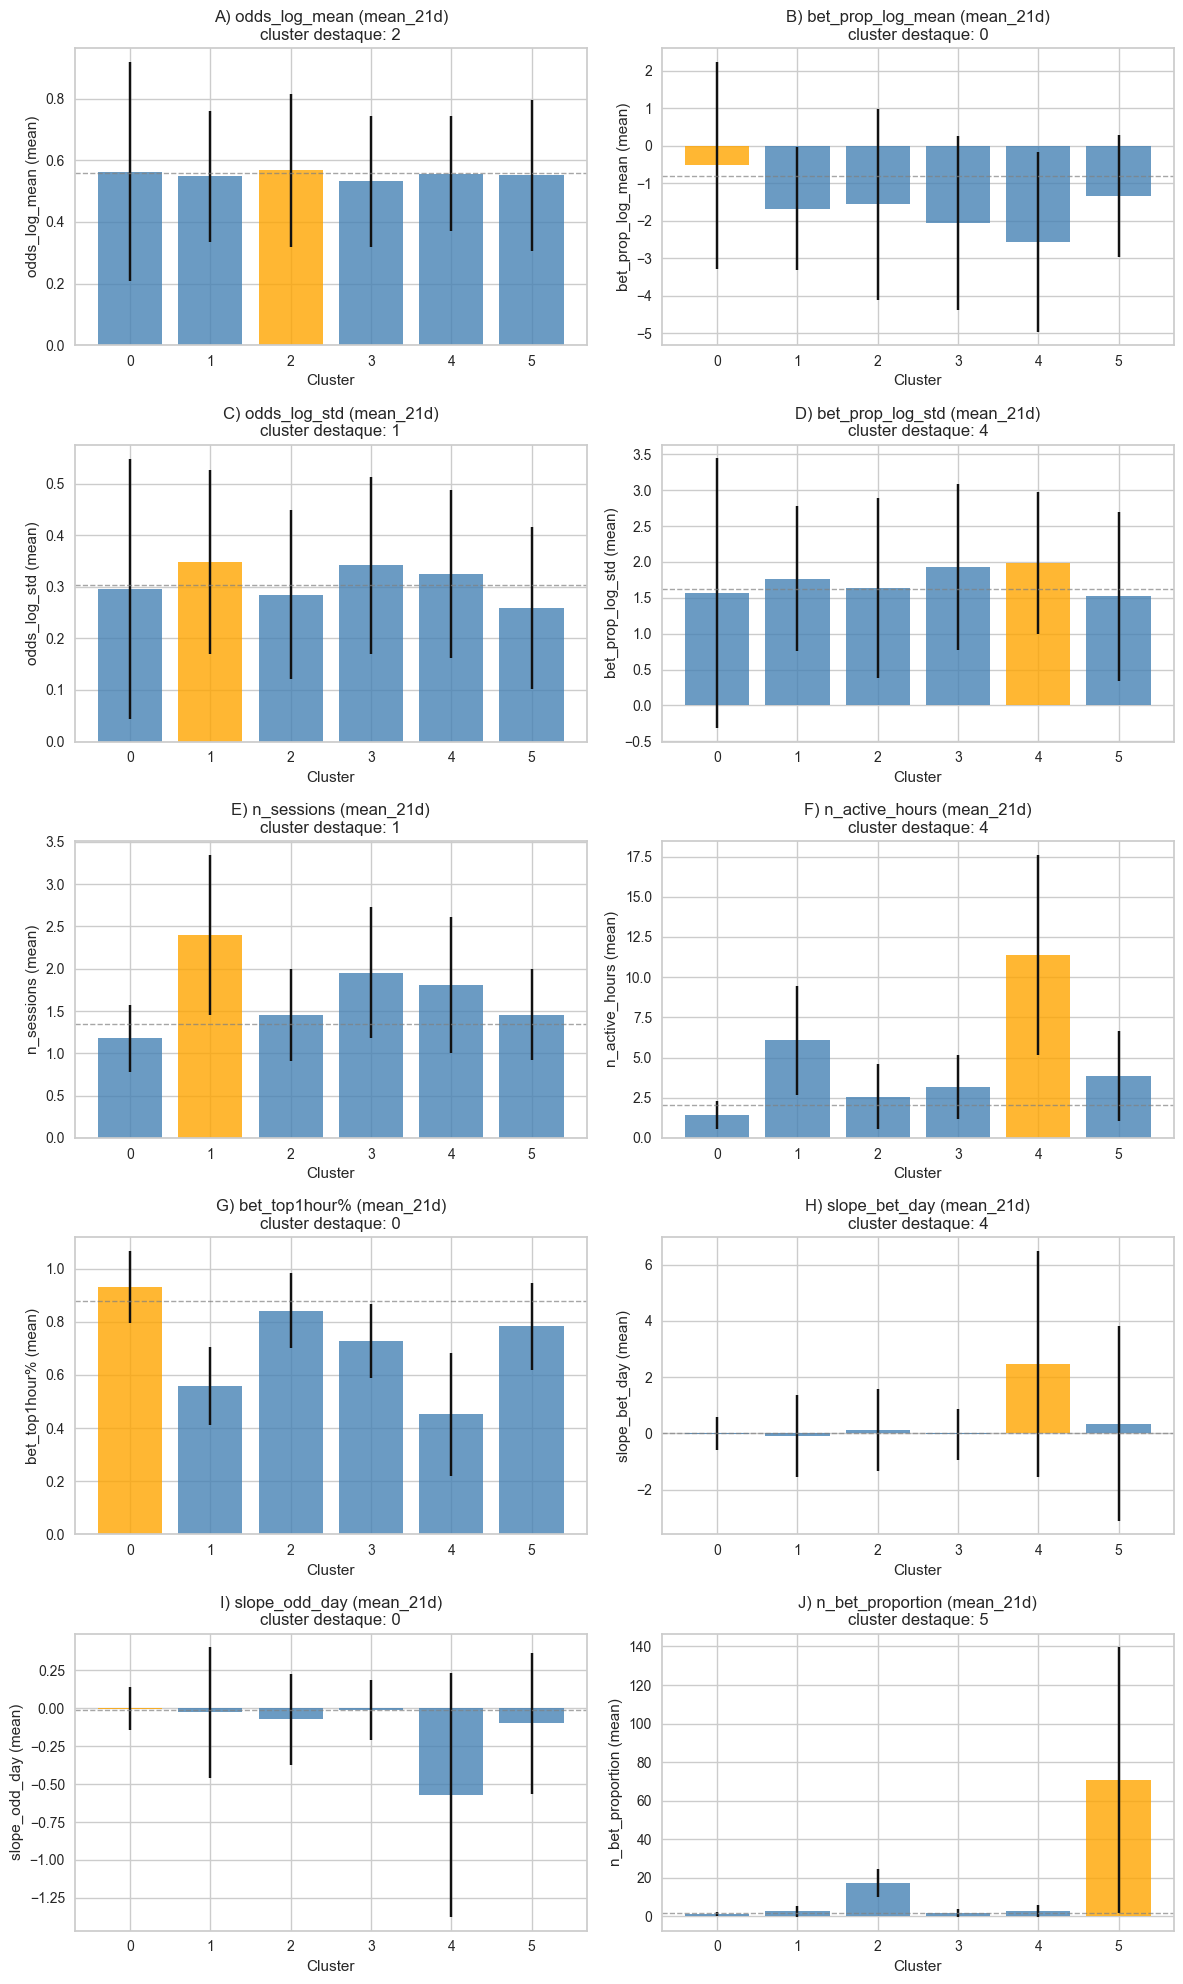

In [205]:
features = [
    "odds_log_mean",
    "bet_prop_log_mean",
    "odds_log_std",
    "bet_prop_log_std",
    "n_sessions",
    "n_active_hours",
    "bet_top1hour%",
    "slope_bet_day",
    "slope_odd_day",
    "n_bet_proportion"
]

plot_cluster_feature_comparisons(
    df=labeled_users,            
    features=features,
    window="21d",
    stat="mean",
    cluster_col="cluster_label",
    save_path="figs/p6.pdf",
)


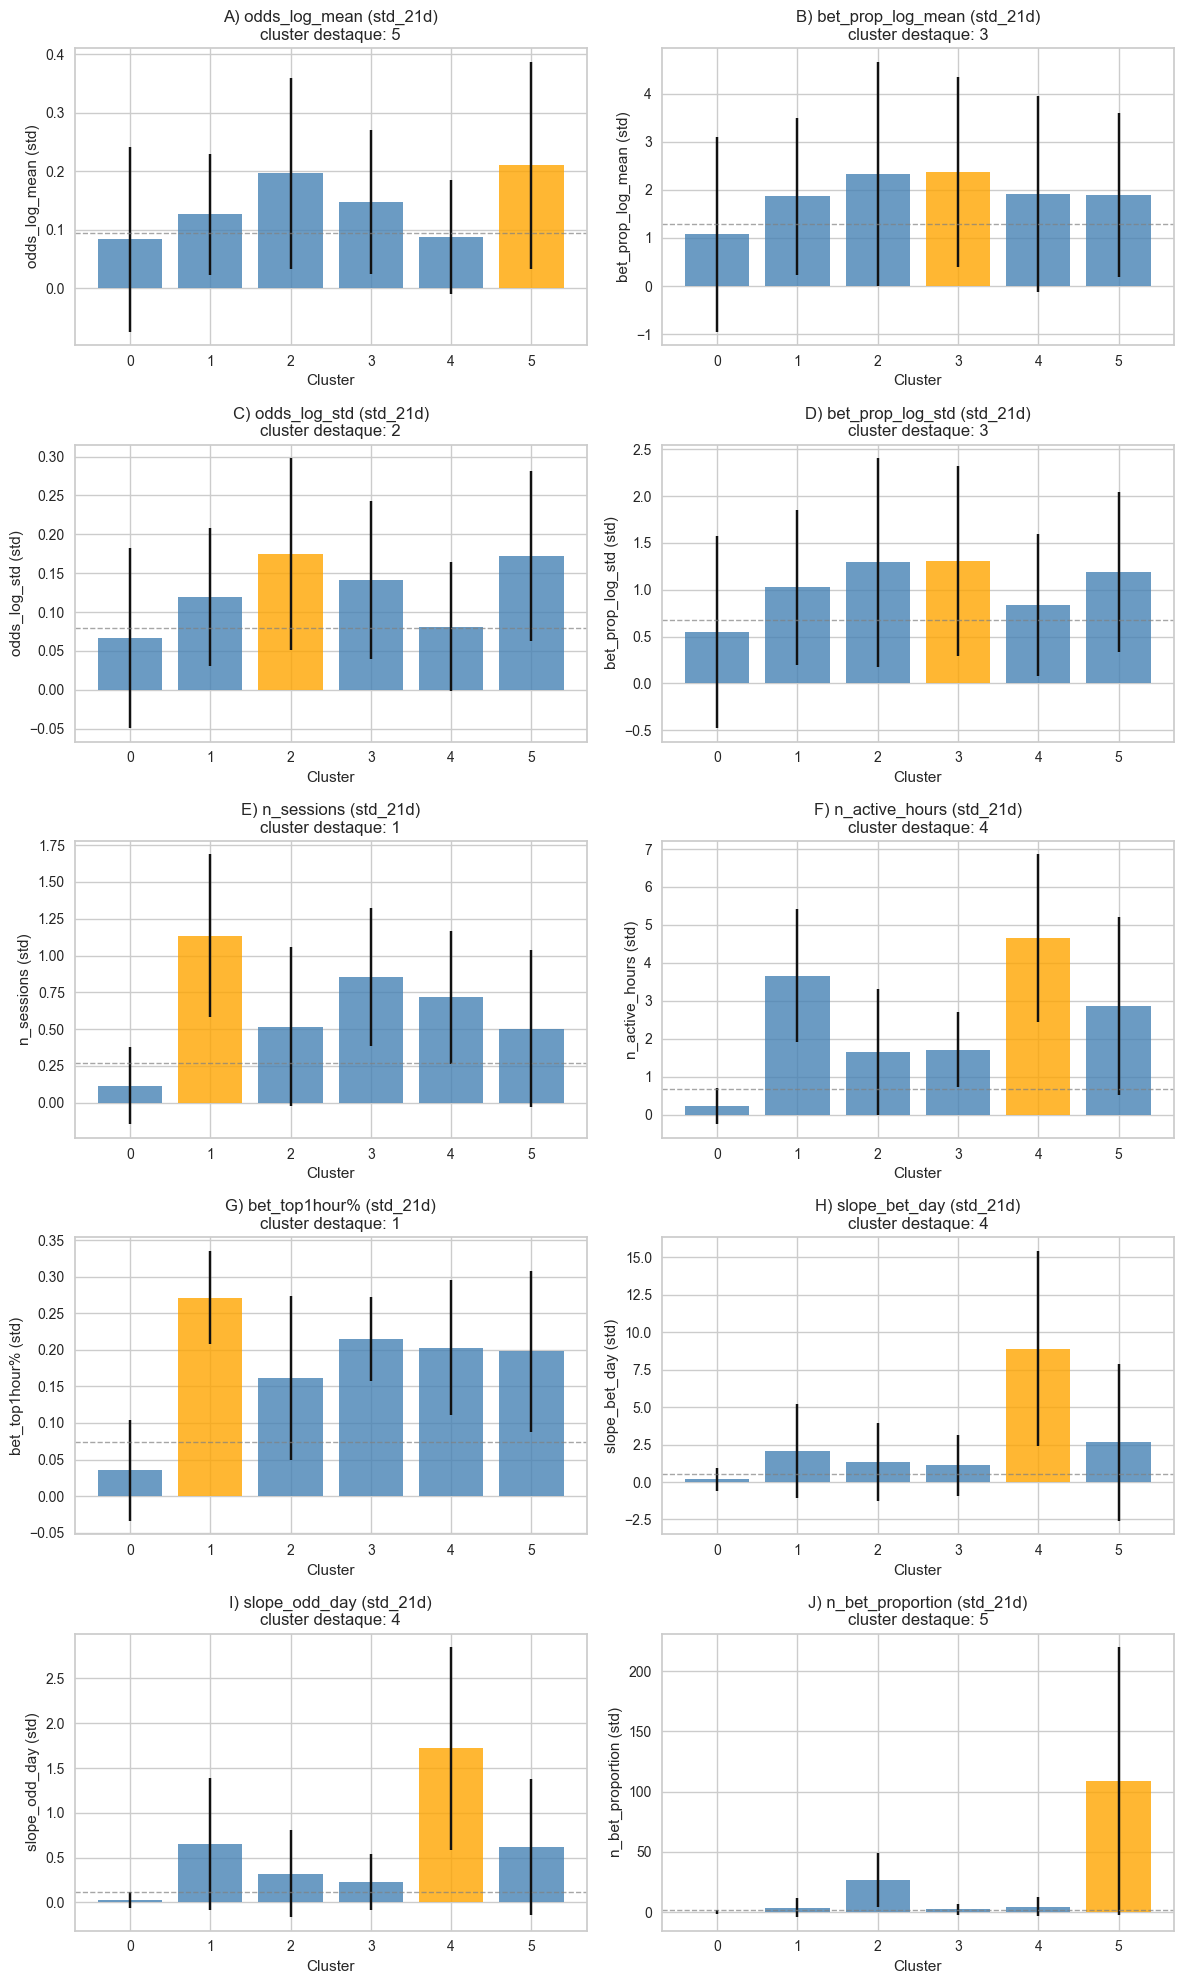

In [206]:
features = [
    "odds_log_mean",
    "bet_prop_log_mean",
    "odds_log_std",
    "bet_prop_log_std",
    "n_sessions",
    "n_active_hours",
    "bet_top1hour%",
    "slope_bet_day",
    "slope_odd_day",
    "n_bet_proportion"
]

plot_cluster_feature_comparisons(
    df=labeled_users,            
    features=features,
    window="21d",
    stat="std",
    cluster_col="cluster_label",
    save_path="figs/p7.pdf",
    
)


In [220]:
def plot_cluster_window_comparisons(
    df: pd.DataFrame,
    feature: str,
    windows: list,              # ["2d", "7d", "14d", ...]
    stat: str = "mean",         # "mean" ou "std"
    cluster_col: str = "cluster_label",
    save_path: str = None
):
    window_cols = {}
    for w in windows:
        col_name = f"{feature}_{stat}_{w}"
        if col_name in df.columns:
            window_cols[w] = col_name

    if not window_cols:
        raise ValueError("Nenhuma coluna encontrada para a combinação feature/stat/windows.")

    clusters = np.sort(df[cluster_col].dropna().unique())

    n_clusters = len(clusters)
    ncols = 2
    nrows = math.ceil(n_clusters / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 4 * nrows))
    axes = np.array(axes).reshape(-1)

    for ax, cluster in zip(axes, clusters):
        tmp = df[df[cluster_col] == cluster]

        means = []
        stds = []
        labels = []

        for w, col_name in window_cols.items():
            vals = tmp[col_name].dropna()
            if len(vals) == 0:
                means.append(np.nan)
                stds.append(0.0)
            else:
                means.append(vals.mean())
                stds.append(vals.std())
            labels.append(w)

        means = np.array(means)
        stds = np.array(stds)

        if np.all(np.isnan(means)):
            idx_max = None
        else:
            idx_max = np.nanargmax(means)

        x = np.arange(len(labels))


        colors = ["steelblue"] * len(labels)
        if idx_max is not None:
            colors[idx_max] = "orange"

        ax.bar(x, means, yerr=stds, capsize=4, alpha=0.8, color=colors)
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.set_xlabel("Janela")
        ax.set_ylabel(f"{feature} ({stat})")
        titulo_feat = feature.replace("_", " ")
        ax.set_title(f"Cluster {cluster} - {titulo_feat}")

  
        all_vals = tmp[list(window_cols.values())].values.flatten()
        all_vals = all_vals[~np.isnan(all_vals)]
        if len(all_vals) > 0:
            overall_mean = all_vals.mean()
            ax.axhline(overall_mean, linestyle="--", linewidth=1, color="gray", alpha=0.7)


    for ax in axes[n_clusters:]:
        ax.set_visible(False)

    # fig.suptitle(
    #     f"Comparação entre janelas por cluster - {feature} ({stat})",
    #     fontsize=16,
    #     y=1.02
    # )
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


In [221]:
    # "odds_log_mean",
    # "bet_prop_log_mean",
    # "odds_log_std",
    # "bet_prop_log_std",
    # "n_sessions",
    # "n_active_hours",
    # "bet_top1hour%",
    # "slope_bet_day",
    # "slope_odd_day",
    # "n_bet_proportion"



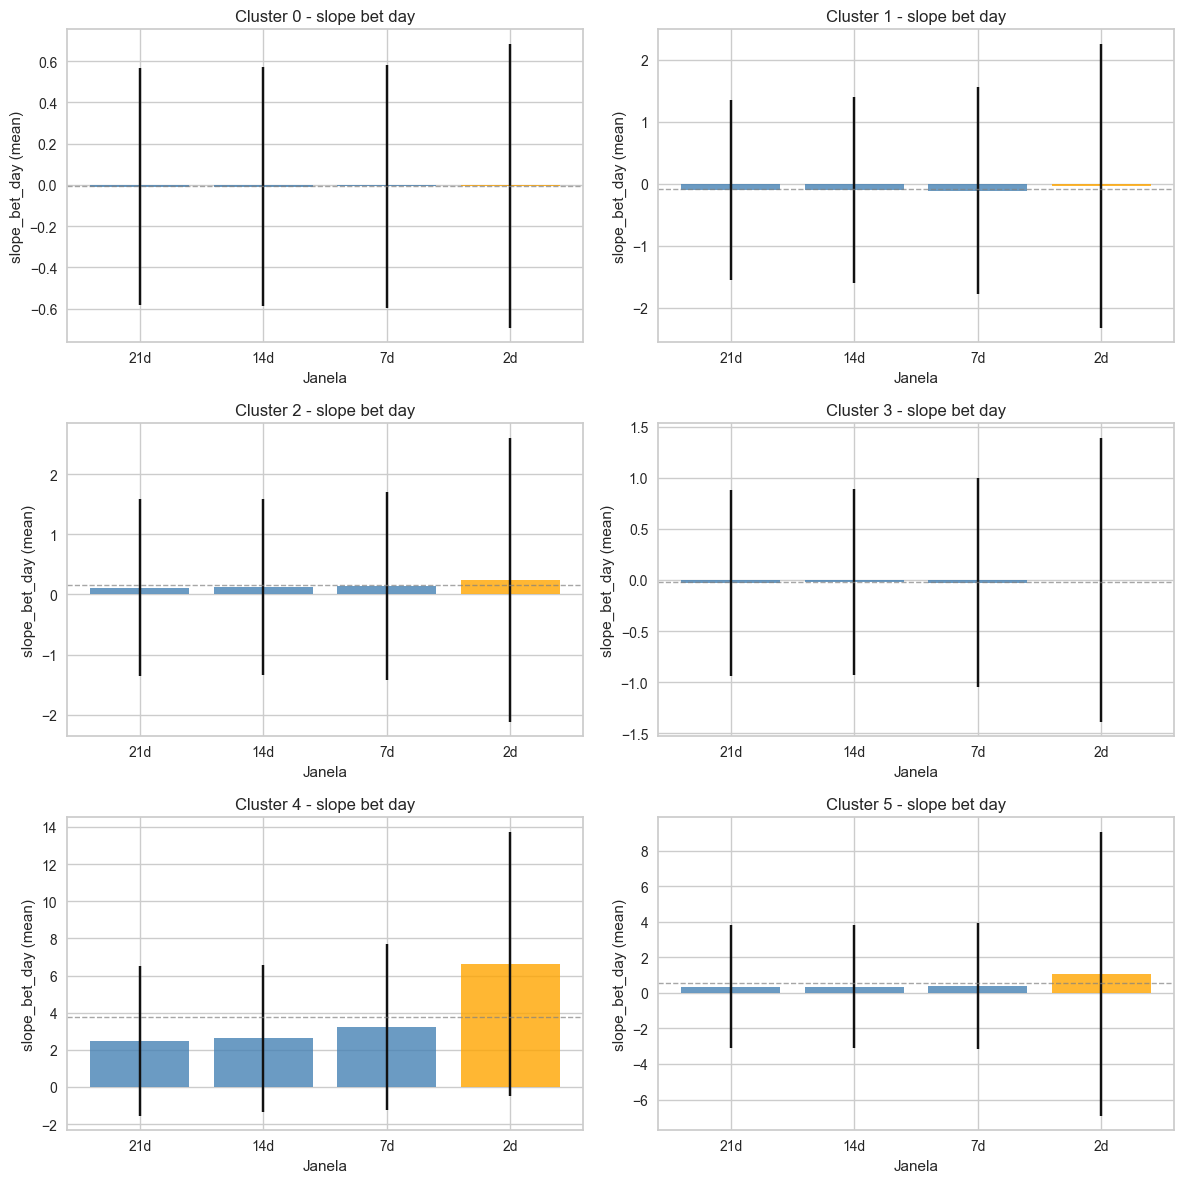

In [224]:
plot_cluster_window_comparisons(
    df=labeled_users,
    feature="slope_bet_day",         
    windows=["21d", "14d", "7d","2d"],
    stat="mean",
    cluster_col="cluster_label",
    save_path='figs/p8.pdf'
    
)


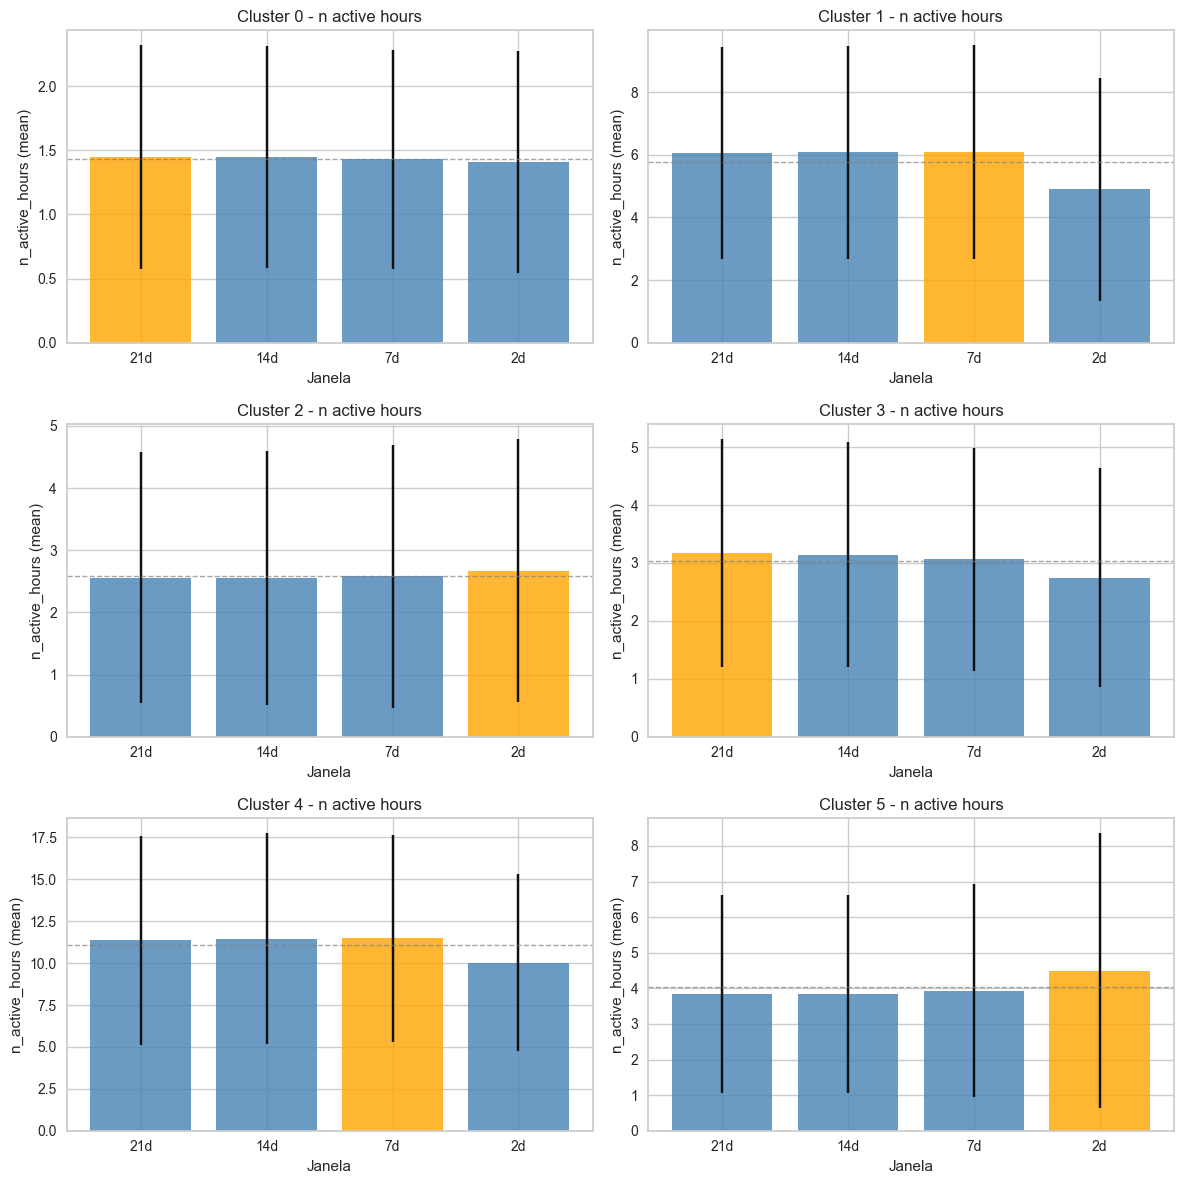

In [225]:
plot_cluster_window_comparisons(
    df=labeled_users,
    feature="n_active_hours",         
    windows=["21d", "14d", "7d","2d"],
    stat="mean",
    cluster_col="cluster_label",
    save_path='figs/p9.pdf'
)


In [ ]:
labeled_users.columns


Index(['user_id', 'odds_log_mean_mean_2d', 'odds_log_mean_std_2d',
       'odds_log_mean_mean_7d', 'odds_log_mean_std_7d',
       'odds_log_mean_mean_14d', 'odds_log_mean_std_14d',
       'odds_log_mean_mean_21d', 'odds_log_mean_std_21d',
       'odds_log_std_mean_2d', 'odds_log_std_std_2d', 'odds_log_std_mean_7d',
       'odds_log_std_std_7d', 'odds_log_std_mean_14d', 'odds_log_std_std_14d',
       'odds_log_std_mean_21d', 'odds_log_std_std_21d',
       'bet_prop_log_mean_mean_2d', 'bet_prop_log_mean_std_2d',
       'bet_prop_log_mean_mean_7d', 'bet_prop_log_mean_std_7d',
       'bet_prop_log_mean_mean_14d', 'bet_prop_log_mean_std_14d',
       'bet_prop_log_mean_mean_21d', 'bet_prop_log_mean_std_21d',
       'bet_prop_log_std_mean_2d', 'bet_prop_log_std_std_2d',
       'bet_prop_log_std_mean_7d', 'bet_prop_log_std_std_7d',
       'bet_prop_log_std_mean_14d', 'bet_prop_log_std_std_14d',
       'bet_prop_log_std_mean_21d', 'bet_prop_log_std_std_21d',
       'n_sessions_mean_2d', 'n_sess

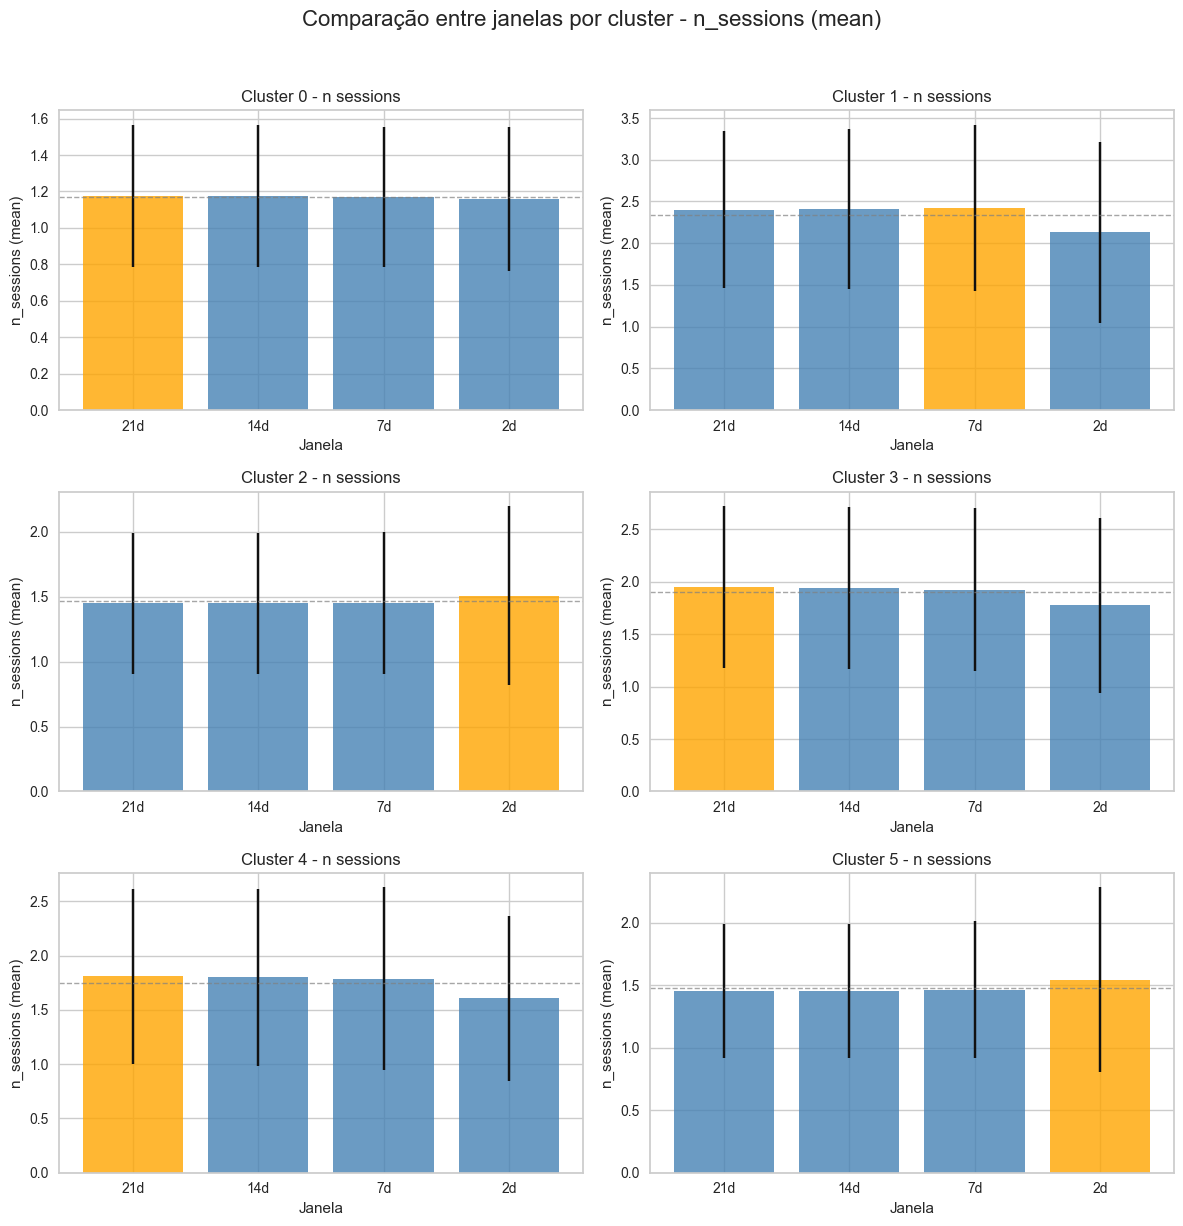

In [ ]:
plot_cluster_window_comparisons(
    df=labeled_users,
    feature="n_sessions",         
    windows=["21d", "14d", "7d","2d"],
    stat="mean",
    cluster_col="cluster_label",
)


In [7]:
columns = [col for col in labeled_users.columns if 'n_sessions' in col and 'mean' in col]
tst = labeled_users[labeled_users['cluster_label'] == 1][['user_id']+columns]
tst.sort_values('n_sessions_mean_30d')


,user_id,n_sessions_mean_2d,n_sessions_mean_7d,n_sessions_mean_14d,n_sessions_mean_30d
23721,1457795,1.0,1.000000,1.000000,1.000000
15255,1380174,1.0,1.000000,1.000000,1.000000
10168,1239589,1.0,1.000000,1.000000,1.000000
19498,1435318,1.0,1.000000,1.000000,1.000000
15171,1378313,1.0,1.000000,1.000000,1.000000
...,...,...,...,...,...
4312,797900,6.5,6.571429,6.642857,6.150000
13145,1331092,6.5,7.285714,7.285714,6.631579
6620,1022144,4.0,7.714286,7.214286,7.000000
262,85716,4.0,7.857143,7.285714,7.043478


In [14]:
user_id = 1022144


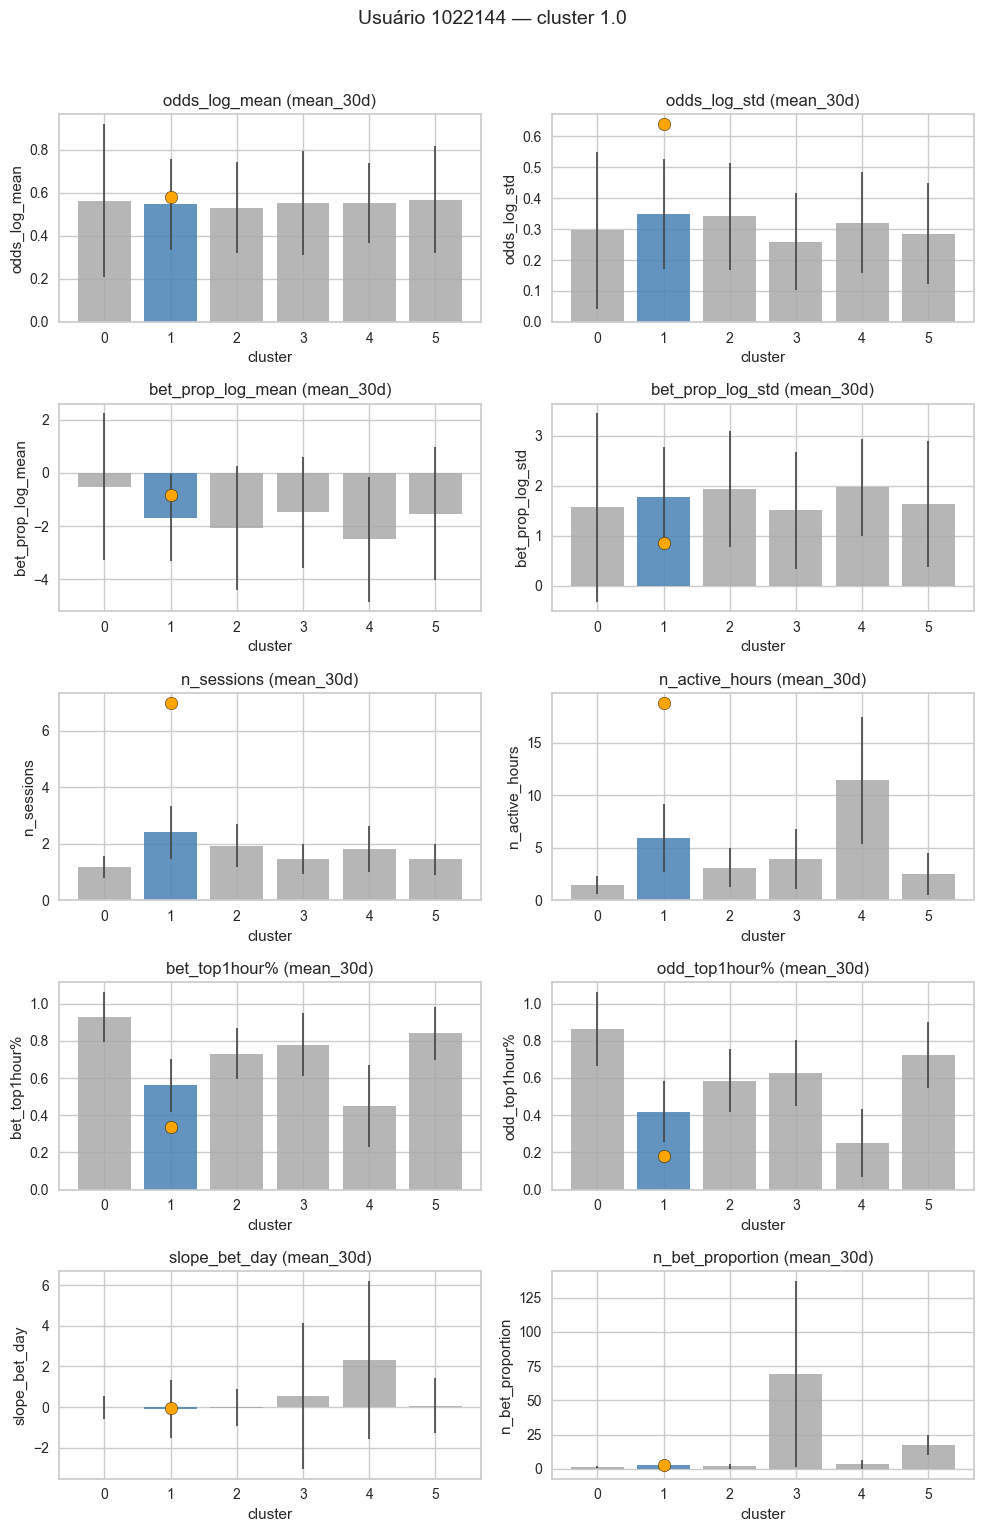

In [16]:
features = [
    "odds_log_mean",
    "odds_log_std",
    "bet_prop_log_mean",
    "bet_prop_log_std",
    "n_sessions",
    "n_active_hours",
    "bet_top1hour%",
    "odd_top1hour%",
    "slope_bet_day",
    "n_bet_proportion"
]

plot_user_vs_clusters(
    df_users=labeled_users,  
    user_id=user_id,
    features=features,
    window="30d",
    stat="mean",
)


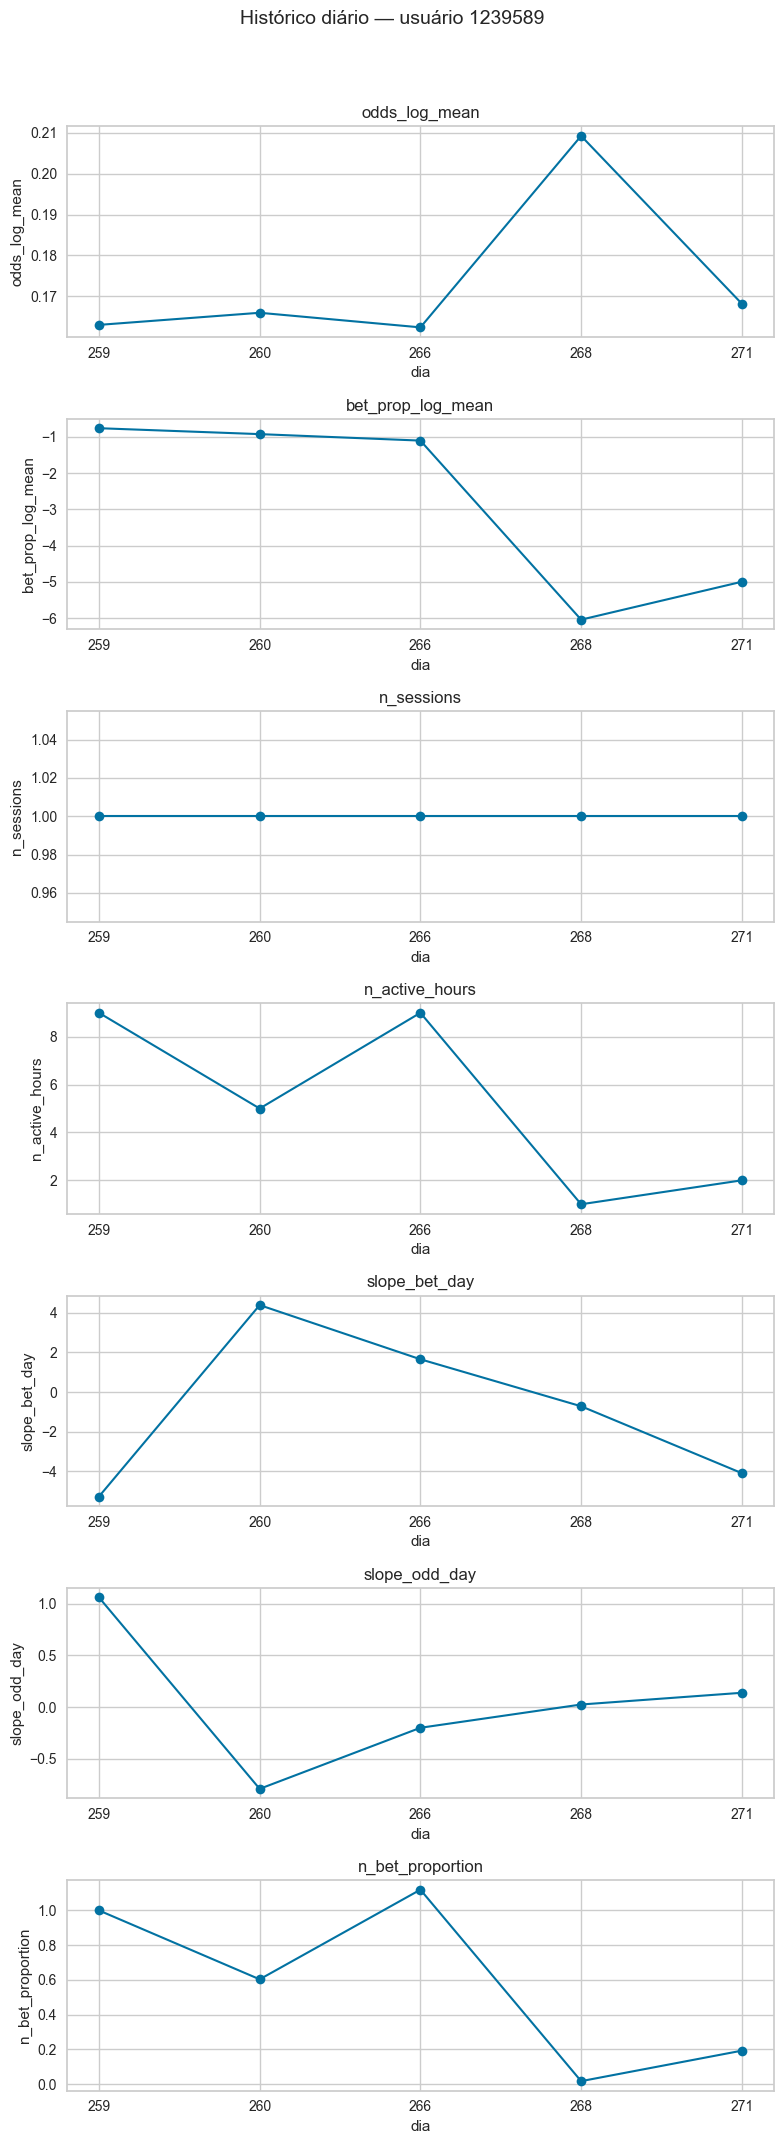

In [13]:
daily_feats = [
    'odds_log_mean', 
    # 'odds_log_std', 
    'bet_prop_log_mean',
    # 'bet_prop_log_std', 
    'n_sessions', 'n_active_hours', 
    # 'bet_top1hour%', 'bet_top2hours%', 'odd_mean_abs_dev_uniform%', 
    'slope_bet_day', 'slope_odd_day', 'n_bet_proportion',
]

plot_user_daily(daily_features, user_id=user_id, features=daily_feats)


In [138]:
day = 257


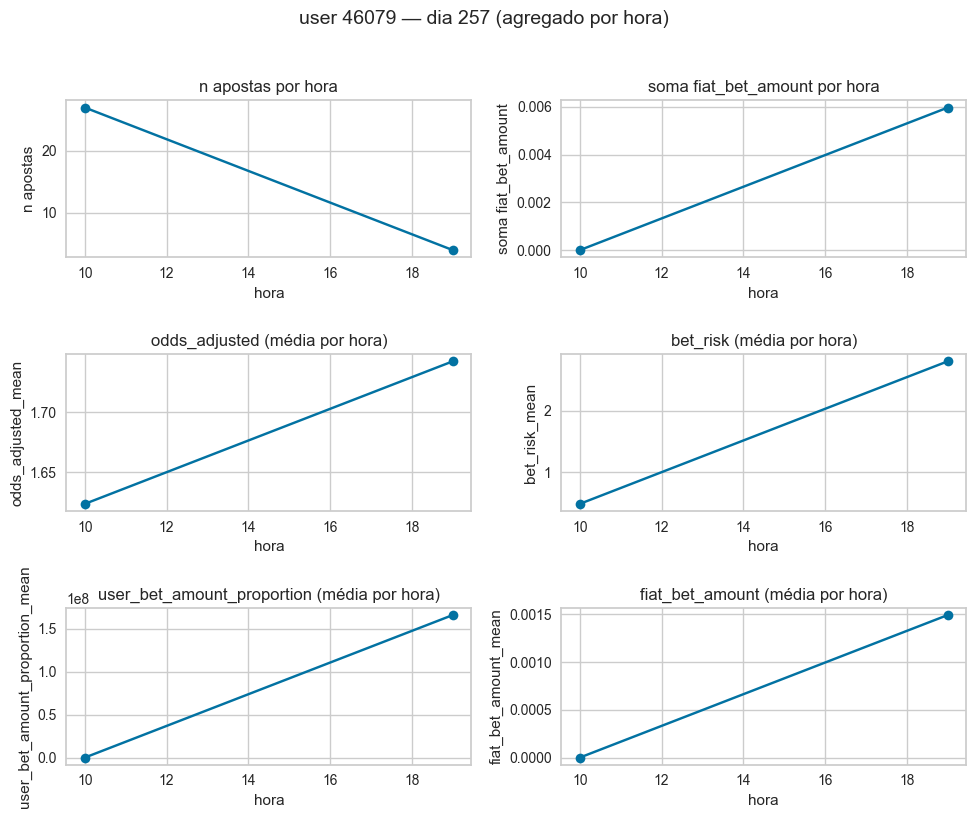

In [139]:
plot_user_day_hourly(
    df=bets,          
    user_id=user_id,
    day_of_year=day  
)


In [141]:
hour = 10


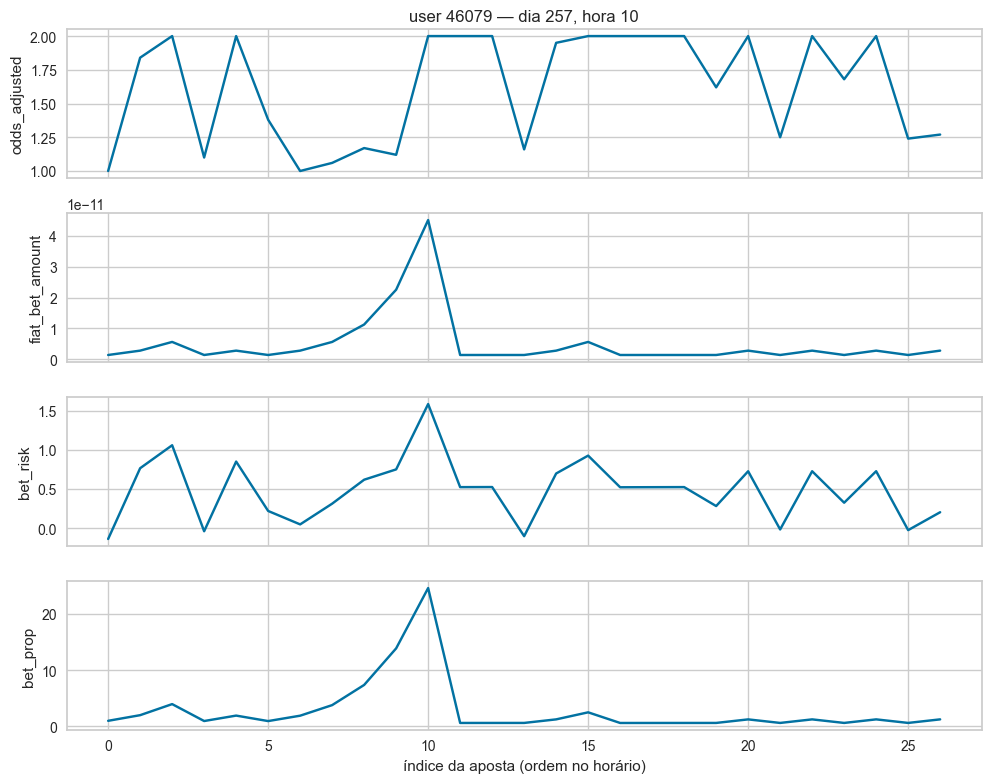

In [142]:
plot_user_hour_bets(
    df=bets,          
    user_id=user_id,
    day_of_year=day,   
    hour=hour  
)


In [63]:
remaining = clustered[clustered['cluster'] == 0]
remaining.drop(columns=['cluster'],inplace=True)


In [64]:
plot_pca(remaining,4)


In [65]:
s = setup(data=remaining, session_id=123)


,Description,Value
0,Session id,123
1,Original data shape,"(25726, 13)"
2,Transformed data shape,"(25726, 13)"
3,Numeric features,13
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,CPU Jobs,-1
9,Use GPU,False


In [66]:

best = create_model("kmeans", num_clusters = 3)
results = pull()


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.7046,4297.6413,1.1978,0,0,0


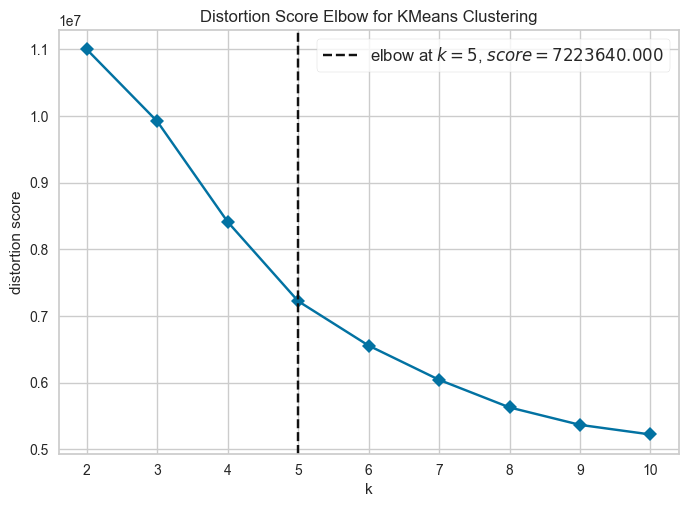

In [67]:
plot_model(best, plot="elbow")  


In [68]:
clustered = assign_model(best)
clustered["cluster"] = (
    clustered["Cluster"]
    .str.replace("Cluster ", "", regex=False)
    .astype(int)
)
labels = clustered["cluster"].values
clustered.drop(columns=['Cluster'], inplace=True)


In [69]:
clustered


,0,1,2,3,4,5,6,7,8,9,10,11,12,cluster
0,-5.013672,13.914816,-0.836406,0.331018,0.964762,0.824352,-1.159272,-1.304118,-1.707820,0.644383,1.063920,-0.600436,-6.600870,0
1,-13.819407,20.041027,-1.177685,-0.288363,0.686438,-1.115452,-0.090843,1.269612,-0.214637,-0.895341,-0.242527,-1.009771,2.547321,0
3,9.189611,10.867785,-2.839204,-1.981985,-13.051668,2.041984,-0.996341,1.170234,1.183415,-0.494800,0.364304,5.007380,-2.077611,0
4,-13.853116,20.263784,0.625104,-1.346178,0.444663,0.227029,-0.165629,0.585994,0.590716,-0.785591,-0.199747,-1.022208,2.930861,0
5,-13.586135,19.047121,-0.776628,0.384398,0.851356,-2.765507,1.366355,0.246150,-1.339525,-0.409058,-0.443610,-0.688371,0.991926,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32097,-13.863569,20.299957,0.014224,-1.055782,0.523290,-0.234765,-0.652817,1.203490,0.390253,-0.900392,-0.174030,-1.058407,3.014288,0
32098,-13.889757,20.384611,-0.560971,-0.867930,0.555940,-0.101997,-0.341750,1.118722,0.463134,-0.937050,-0.191085,-1.115758,3.553261,0
32099,-13.771671,19.974100,2.540904,-1.908182,0.317588,0.775590,-0.283054,-0.086203,0.388179,-0.257816,-0.265913,-0.617329,-1.274111,0
32100,-13.854328,20.267342,0.608209,-1.342005,0.444710,0.251940,-0.130124,0.559293,0.606090,-0.781158,-0.201888,-1.021519,2.930669,0


In [70]:
pd.Series(labels).value_counts().sort_index()


0    23995
1     1226
2      505
Name: count, dtype: int64

In [72]:
plot_results2(clustered)


In [74]:
cluster_labels = pd.Series(labels, name="cluster")


In [75]:
labeled_users2 = users.copy()
labeled_users2['cluster_label'] = cluster_labels
labeled_users2 = labeled_users2.dropna()


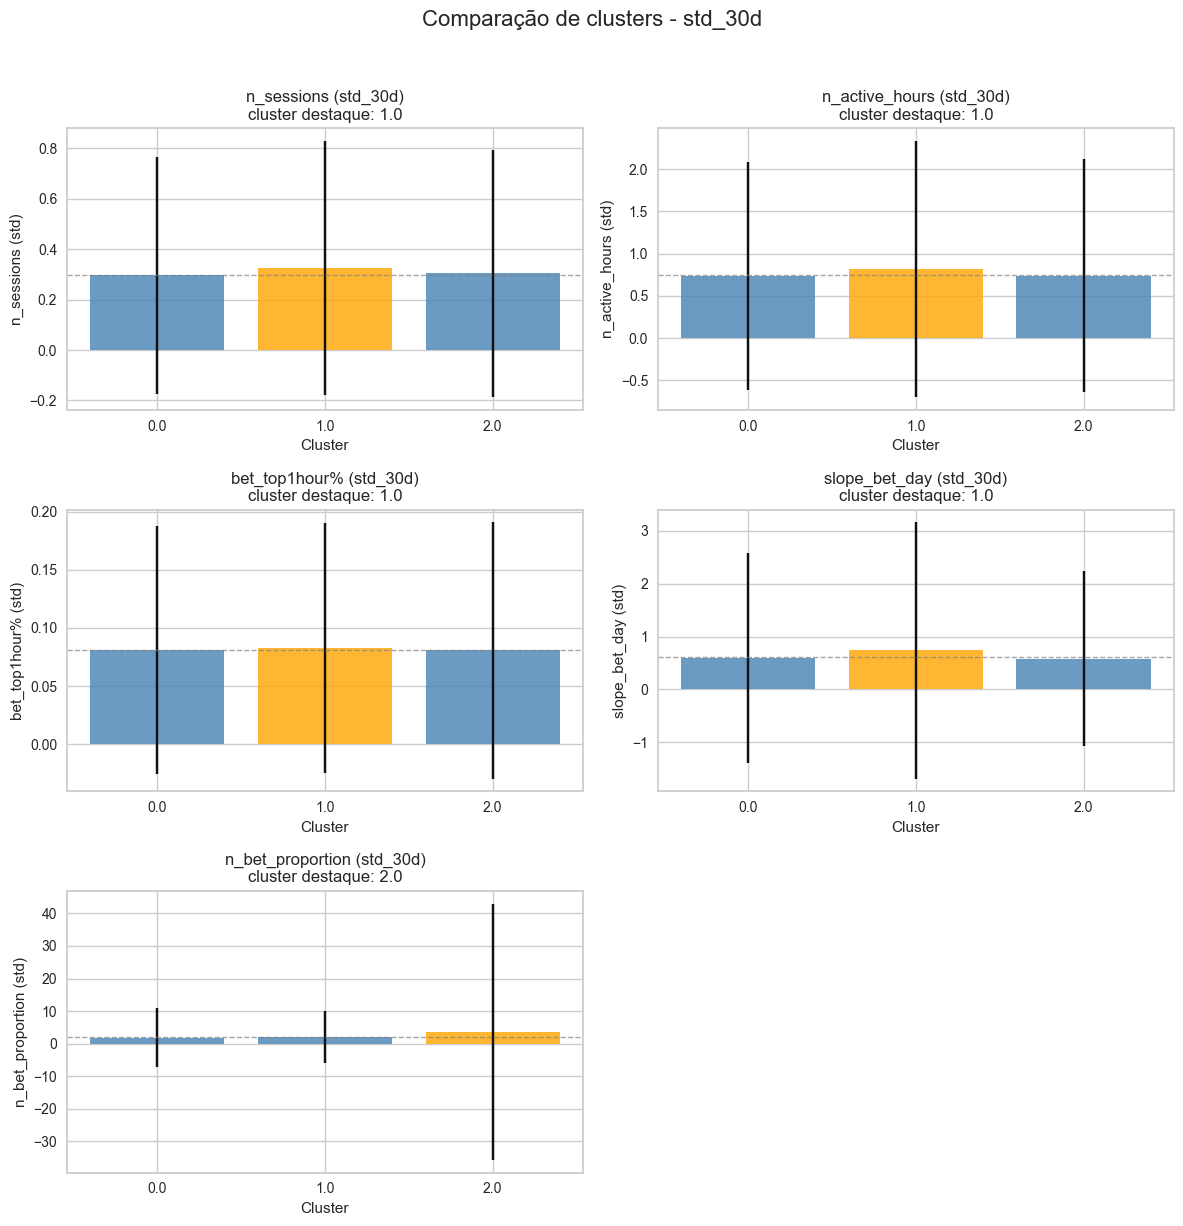

In [78]:
features = [
    "odds_mean",
    "odds_std",
    "bet_prop_mean",
    "n_sessions",
    "n_active_hours",
    "bet_top1hour%",
    # "odd_top1hour%",
    "slope_bet_day",
    "n_bet_proportion"
]

plot_cluster_feature_comparisons(
    df=labeled_users2,            
    features=features,
    window="30d",
    stat="std",
    cluster_col="cluster_label",
)


In [229]:
daily_features


,user_id,day_of_year,odds_log_mean,odds_log_std,bet_prop_log_mean,bet_prop_log_std,n_sessions,n_active_hours,bet_top1hour%,bet_top2hours%,bet_top4hours%,bet_mean_abs_dev_uniform%,odd_top1hour%,odd_top2hours%,odd_top4hours%,odd_mean_abs_dev_uniform%,slope_bet_day,slope_odd_day,n_bet_proportion
0,44,253,0.045360,0.027368,0.000000,0.000000,1.0,2,0.500000,1.000000,1.000000,0.076389,0.505995,1.000000,1.000000,0.076389,0.000000,0.001335,1.000000
1,44,254,0.537515,0.259239,1.242422,0.736760,1.0,2,0.825483,1.000000,1.000000,0.076389,0.515239,1.000000,1.000000,0.076389,-0.029744,-0.013300,1.666667
2,44,255,0.029559,0.000000,-0.069071,0.000000,1.0,1,1.000000,1.000000,1.000000,0.079861,1.000000,1.000000,1.000000,0.079861,-0.000210,0.000090,0.312500
3,44,257,0.036531,0.027343,0.324303,0.698184,3.0,3,0.559135,0.782729,0.782729,0.072917,0.338710,0.670968,0.670968,0.072917,0.001503,0.000293,1.342282
4,44,259,0.095418,0.104053,-0.068377,0.002970,1.0,1,1.000000,1.000000,1.000000,0.079861,1.000000,1.000000,1.000000,0.079861,-0.009365,0.013068,4.866970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130639,1503508,274,0.469348,0.309348,1.480713,2.308513,1.0,1,1.000000,1.000000,1.000000,0.079861,1.000000,1.000000,1.000000,0.079861,-0.042490,-0.013468,1.000000
130640,1503513,274,0.192760,0.105671,2.745244,2.152429,1.0,1,1.000000,1.000000,1.000000,0.079861,1.000000,1.000000,1.000000,0.079861,-0.064454,-0.004526,1.000000
130641,1503516,274,0.386987,0.334752,-8.095021,10.176622,1.0,1,1.000000,1.000000,1.000000,0.079861,1.000000,1.000000,1.000000,0.079861,0.095029,-0.004543,1.000000
130642,1503542,274,0.165514,0.000000,0.000000,0.000000,1.0,1,1.000000,1.000000,1.000000,0.079861,1.000000,1.000000,1.000000,0.079861,0.000000,-0.000648,1.000000
